In [1]:
import numpy as np, matplotlib.pyplot as plt, xarray as xr, netCDF4 as nc, wrf
from mpltern.ternary.datasets import get_triangular_grid
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy as cp
from analysis_utils import *
#from sklearn import cluster
#import sklearn as sk
from sklearn.preprocessing import normalize
import PIL, tqdm, os
#from scipy import stats
import seaborn as sns
#from matplotlib.cm import get_cmap
#from cartopy.feature import NaturalEarthFeature
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
import haversine as hs
import statsmodels.stats.api as sms
from ipywidgets import interact, IntSlider
from joblib.externals.loky import set_loky_pickler

import functools
import operator
#set_loky_pickler("dill")

In [2]:
Milbrandt3 = '/nird/projects/NS9600K/brittsc/WRF_output_Stian/Milbrandt_d03_red_2'
#Milbrandt2 = '/nird/projects/NS9600K/brittsc/WRF_output_Stian/Milbrandt_d02_reduced_full'

MorrisonDefault3 = '/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d03_2019-11-11_12:00:00'
MorrisonAdapted3 = '/nird/projects/NS9600K/brittsc/221126_Morrison_adapted_no_SIP/wrfout_d03_2019-11-11_12:00:00'
MorrisonAdaptedSIP3 = '/nird/projects/NS9600K/brittsc/230213_Morrison_moved_NISG_SIP/wrfout_d03_2019-11-11_12:00:00'


#Mil2 = xr.open_dataset(Milbrandt2, engine='netcdf4')
Mil3 = xr.open_dataset(Milbrandt3, engine='netcdf4')

def convert():
    set_loky_pickler("dill")

    MD3 = xr.open_dataset(MorrisonDefault3, engine='netcdf4').isel(Time=slice(200, -1), bottom_top=slice(0, 85))
    MA3 = xr.open_dataset(MorrisonAdapted3, engine='netcdf4').isel(Time=slice(200, -1), bottom_top=slice(0, 85))
    MAS3 = xr.open_dataset(MorrisonAdaptedSIP3, engine='netcdf4').isel(Time=slice(200, -1), bottom_top=slice(0, 85))


    def parallel_rhos(i):
        import xarray as xr, wrf
        datas = ['/nird/projects/NS9600K/brittsc/211108_WRF_NYA/wrfout_d03_2019-11-11_12:00:00',
                '/nird/projects/NS9600K/brittsc/221126_Morrison_adapted_no_SIP/wrfout_d03_2019-11-11_12:00:00',
                '/nird/projects/NS9600K/brittsc/230213_Morrison_moved_NISG_SIP/wrfout_d03_2019-11-11_12:00:00']
        data = xr.open_dataset(datas[i], engine='netcdf4').isel(Time=slice(200, -1), bottom_top=slice(0, 85))

        P = data['P'] + data['PB']
        theta = data['T'] + 300 #+ data['T00'] NO clue why
        T = wrf.tk(P, theta)
        Tv = wrf.tvirtual(T, data['QVAPOR'], units='K')
        d = P / (287 * Tv)
        return d

    print('Calculating density')
    with tqdm_joblib('Calculating density', total=3) as progress_bar:
        rhos = Parallel(n_jobs=3)(delayed(parallel_rhos)(i) for i in range(3))
    print('------------------------------------------------------')
    print('Converting units kg/kg -> g/m3')
    for i, da in enumerate([MD3, MA3, MAS3]):
        convert_vars_gm3 = ['QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP']
        for var in tqdm.tqdm(convert_vars_gm3, desc=f'Dataset {i + 1}/3'):
            with xr.set_options(keep_attrs=True):
                da[var] = convert_to_gm3(da[var], rhos[i])
                da[var].attrs['units'] = 'g m-3'
    return MD3, MA3, MAS3

MD3, MA3, MAS3 = convert()

domain='d03'

Calculating density


100%|██████████| 3/3 [01:38<00:00, 32.83s/it]


------------------------------------------------------
Converting units kg/kg -> g/m3


Dataset 3/3: 100%|██████████| 6/6 [01:07<00:00, 11.25s/it]


### Helpers

In [8]:
def all_ice(data, t=None, mass=True):
    if mass:
        vars = ['QICE', 'QGRAUP', 'QSNOW']
    else:
        vars = ['QNICE', 'QNSNOW', 'QNGRAUPEL']

    if t is not None:
        ice = data[vars[0]].isel(Time=t).where(data[vars[0]].isel(Time=t) > 0, other=0)
        for e in vars[1:]:
            ice += data[e].isel(Time=t).where(data[e].isel(Time=t) > 0, other=0)
        return ice

    else:
        ice = data[vars[0]].where(data[vars[0]] > 0, other=0)
        for e in vars[1:]:
            ice += data[e].where(data[e] > 0, other=0)
        return ice

def all_liquid(data, t=None, mass=True):
    if mass:
        vars = ['QCLOUD', 'QRAIN']
    else:
        vars = ['QNCLOUD', 'QNRAIN']

    if t is not None:
        liquid = data[vars[0]].isel(Time=t).where(data[vars[0]].isel(Time=t) > 0, other=0) + \
        data[vars[1]].isel(Time=t).where(data[vars[1]].isel(Time=t) > 0, other=0)
        return liquid

    else:
        liquid = data[vars[0]].where(data[vars[0]] > 0, other=0) + \
        data[vars[1]].where(data[vars[1]] > 0, other=0)
        return liquid

def cldmsk(inp, data, t=None, cld_thrsh=0.10):
    if t is not None:
        return inp * xr.where(data.CLDFRA.isel(Time=t) > cld_thrsh, x=1, y=np.nan)
    else:
        return inp * xr.where(data.CLDFRA > cld_thrsh, x=1, y=np.nan)

def clip_to_region(data, datapath, minll=(78, 11), maxll=(79, 12), clip_to_data=None):#minlat, minlon, maxlat, maxlon):
    if clip_to_data is not None:
        Ds = nc.Dataset(clip_to_data)
        mxx, mxy = Ds['XLONG'].shape[2] - 1, Ds['XLONG'].shape[1] - 1
        minll = wrf.xy_to_ll(Ds, 0, 0)
        maxll = wrf.xy_to_ll(Ds, mxy, mxx)
        
    minx, miny = [int(e) for e in wrf.ll_to_xy(nc.Dataset(datapath), float(minll[0]), float(minll[1]))]
    maxx, maxy = [int(e) for e in wrf.ll_to_xy(nc.Dataset(datapath), float(maxll[0]), float(maxll[1]))]
    return data.isel(west_east=slice(minx, maxx), south_north=slice(miny, maxy))

def lndmsk(data):
    return xr.where(data.XLAND.isel(Time=1) == 1, x=1, y=np.nan)

def wtrmsk(data):
    return xr.where(data.XLAND.isel(Time=1) == 2, x=1, y=np.nan)
    
def iwf_calc(data, mass=False, t=None, cld_thrsh=0.5):
    ALL_ICE = all_ice(data, mass=mass, t=t)
    ALL_LIQUID = all_liquid(data, mass=mass, t=t)
    return cldmsk(ALL_ICE / (ALL_ICE + ALL_LIQUID), data=data, cld_thrsh=cld_thrsh, t=t)

def composition_msk(data, thrsh=0.05, iwf=None, mass=True):
    if iwf is None:
        iwf = iwf_calc(data, mass=mass)

    mixed = iwf.where(iwf > thrsh, other=np.nan)
    mixed = xr.where(mixed < 1 - thrsh, x = 1, y=np.nan)

    ice = xr.where(iwf > 1 - thrsh, x=1, y=np.nan)
    liquid = xr.where(iwf < thrsh, x=1, y=np.nan)
    return liquid, mixed, ice

def find_top(data, datapath, cld_thrsh=0.1, t=None):
    h = wrf.getvar(nc.Dataset(datapath), 'z').to_numpy()

    if t is not None:
        hc = xr.where(data.CLDFRA.isel(Time=t, bottom_top=slice(0,84)) > cld_thrsh, x=1, y=0) * h[:84, :, :]
    else:
        hc = xr.where(data.CLDFRA.isel(bottom_top=slice(0,84)) > cld_thrsh, x=1, y=0) * h[:84, :, :]
    
    cloudtop = hc.argmax(dim='bottom_top')
    return cloudtop.rename('Cloud-top level')

def select_top(indata, cloudtop, n_levels=10):
    return indata.where((indata.bottom_top > cloudtop - n_levels) 
                        & (indata.bottom_top <= cloudtop) 
                        & (indata.bottom_top != 0), other=np.nan)

def calc_T(data, t):
    return wrf.tk(data.P.isel(Time=t) + data.PB.isel(Time=t), data.T.isel(Time=t) + 300) - 273.15
def calc_W(data, t):
    return wrf.destagger(data.W.isel(Time=t), stagger_dim=1, meta=True)

def consecutive(arr):
    return np.split(arr, np.where(np.diff(arr) != 1)[0] + 1)

def animate(plot_func, data=Mil3, n_timesteps='all', step_interval=1, anim_title='animation', duration=200, mp4=False, skip_spinup=0):
    '''
    Create an animation of time evolution through iterating a plotting function.
    Parameters:
    -----------
    plot_func        - (function) function for generating figure with one or more subplots
    step_interval    - (int) number of timesteps to forward each frame in animation, default is 1
    n_frames         - (int) number of frames to use in animation, default is None (full timerange is used)
    anim_title       - (string) name of the saved gif (without extension), default is 'animation'
    duration         - (int) time in seconds determining the length of the animation (determines also the speed), default is 200
    skip_spinup      - (int) number of timesteps to skip due to model spinup time, default is 0
    '''
    
    frames = []
    if n_timesteps == 'all':
        n_timesteps = len(data['XTIME'][:]) - skip_spinup
    for frame in tqdm.tqdm(range(skip_spinup, skip_spinup + n_timesteps)):
        framename = f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/plots/{frame}.png'
        t = frame * step_interval
        fig = plot_func(frame, data=data)
        fig.savefig(f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/plots/{frame}')
        frames.append(PIL.Image.open(framename))
        plt.close()
        os.remove(framename)
    
    title = f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/animations/{anim_title}.gif'
    frames[0].save(title, format='GIF', append_images=frames[1:], save_all=True, duration=duration, loop=1)

import time
class timer:
    def __init__(self):
        self._start_time = None
        self._round_time = None

    def start(self):
        self._start_time = time.perf_counter()

    def round(self):
        if self._round_time is None:
            t = time.perf_counter() - self._start_time
            self._round_time = time.perf_counter()
        else:
            t = time.perf_counter() - self._round_time
            self._round_time = time.perf_counter()
        return f'Elapsed time: {t:0.4f} seconds'
    
    def stop(self):
        t = time.perf_counter() - self._start_time
        self._start_time = None
        self._round_time = None
        return f'Elapsed time: {t:0.4f} seconds.'

def flatten_list(lst):
    try:
        return functools.reduce(operator.iconcat, lst, [])
    except TypeError:
        return []



In [ ]:
def f(x):
    MD3.QNICE.isel(Time=x).sum(dim='south_north').plot(levels=np.arange(0, 15001, 100), cmap='Reds')

interact(f, x=IntSlider(min=0, max=231))

### Clipping to region

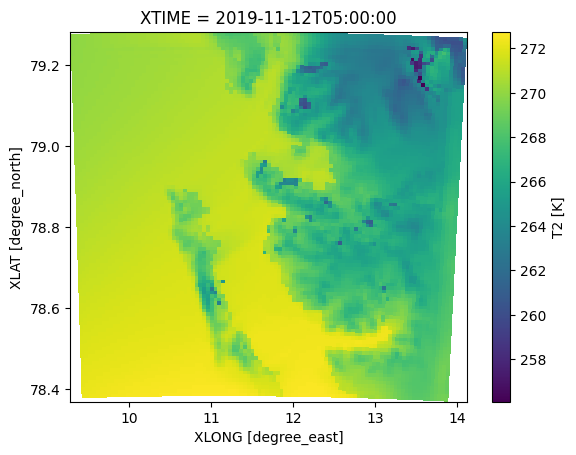

In [28]:
Mil3.T2.isel(Time=4).plot(x='XLONG', y='XLAT')

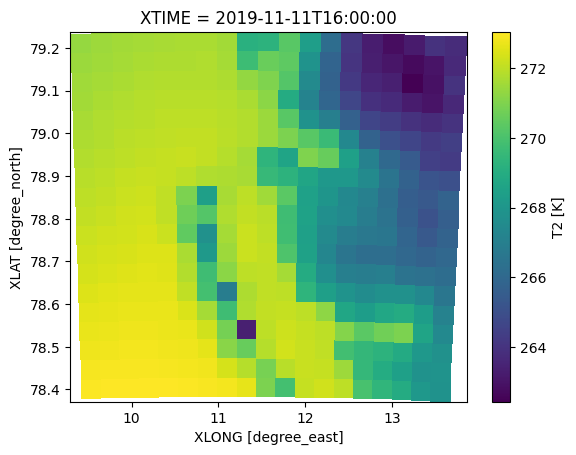

In [29]:
#D = clip_to_region(Mil2, Milbrandt2, 
#                   wrf.xy_to_ll(nc.Dataset(Milbrandt3), 0, 0), 
#                   wrf.xy_to_ll(nc.Dataset(Milbrandt3), 99, 99))

D = clip_to_region(Mil2, Milbrandt2, clip_to_data=Milbrandt3)

D.T2.isel(Time=4).plot(x='XLONG', y='XLAT')

# All cloud

### Stats

In [5]:
IWF = iwf_calc(Mil3, mass=True, cld_thrsh=0.5)
LIQUID, MIXED, ICE = composition_msk(Mil3, iwf=IWF)

In [6]:
def print_stats(data, ice, mixed, liquid, iwf):
    print('Over land:')
    land = lndmsk(data)
    water = wtrmsk(data)
    print('Ice: ', int((ice * land).count()), ', ', round(float((ice * land).count() / (iwf * land).count()) * 100, 2), '%')
    print('Mixed: ', int((mixed * land).count()), ', ', round(float((mixed * land).count() / (iwf * land).count()) * 100, 2), '%')
    print('Liquid: ', int((liquid * land).count()), ', ', round(float((liquid * land).count() / (iwf * land).count()) * 100, 2), '%')
    print('Over water:')
    print('Ice: ', int((ice * water).count()), ', ', round(float((ice * water).count() / (iwf * water).count()) * 100, 2), '%')
    print('Mixed: ', int((mixed * water).count()), ', ', round(float((mixed * water).count() / (iwf * water).count()) * 100, 2), '%')
    print('Liquid: ', int((liquid * water).count()), ', ', round(float((liquid * water).count() / (iwf * water).count()) * 100, 2), '%')

In [7]:
print_stats(Mil3, ICE, MIXED, LIQUID, IWF)

Over land:
Ice:  8868941 ,  20.08 %
Mixed:  8914048 ,  20.19 %
Liquid:  26378131 ,  59.73 %
Over water:
Ice:  12356281 ,  33.72 %
Mixed:  5816906 ,  15.87 %
Liquid:  18469147 ,  50.4 %


I just played around a bit with the number concentrations now and it looks like it doesn't change the structure that much. When I don't time the ice numbers by factor 1000 and just calculate the IWF as normal then the number of grid cells with "only" ice actually increases at the expense of mixed phase occurences. So all I see is that mixed phase occurence is reduced from 20% to 10% of all in-cloud grid cells. I guess that is logical since the balance is now just so dependent on presence of liquid - either there is liquid there to dominate (IWF=0), or not (IWF=1).

When I looked at the vertical structure it looks like the occurences of mixed phase still is right in between the pure ice top and the pure liquid middle of the cloud which makes sense. But I also took a look at some of these grid cells to see the composition and found that the liquid water in them is classified by wrf as rain and not cloud. Does that make any sense? How can the droplets at the very top of the cloud, above all of the other supercooled cloud droplets, be rain? Should they not be too heavy to form or be brought up here? Or is it just that these are the only ones large enough to "survive" the scavenging from the ice?  

### Animation

In [80]:
def animate(plot_func, n_timesteps='all', step_interval=1, anim_title='animation', duration=200, mp4=False, skip_spinup=0):
    '''
    Create an animation of time evolution through iterating a plotting function.
    Parameters:
    -----------
    plot_func        - (function) function for generating figure with one or more subplots
    step_interval    - (int) number of timesteps to forward each frame in animation, default is 1
    n_frames         - (int) number of frames to use in animation, default is None (full timerange is used)
    anim_title       - (string) name of the saved gif (without extension), default is 'animation'
    duration         - (int) time in seconds determining the length of the animation (determines also the speed), default is 200
    skip_spinup      - (int) number of timesteps to skip due to model spinup time, default is 0
    '''
    
    frames = []
    if n_timesteps == 'all':
        n_timesteps = len(Mil3['XTIME'][:]) - skip_spinup
    for frame in tqdm.tqdm(range(skip_spinup, skip_spinup + n_timesteps)):
        framename = f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/plots/{frame}.png'
        t = frame * step_interval
        fig = plot_func(frame)
        fig.savefig(f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/plots/{frame}')
        frames.append(PIL.Image.open(framename))
        plt.close()
        os.remove(framename)
    
    title = f'/tos-project2/NS9600K/brittsc/WRF_output_Stian/animations/{anim_title}.gif'
    frames[0].save(title, format='GIF', append_images=frames[1:], save_all=True, duration=duration, loop=1)
#animate(plot_CT, anim_title='CloudTopAnimation_d03')

## 2D Histograms

In [15]:
#t = slice(30, 60)
#T = wrf.tk(Mil3.P.isel(Time=t) + Mil3.PB.isel(Time=t), Mil3.T.isel(Time=t) + 300) - 273.15
#W = wrf.destagger(Mil3.W.isel(Time=t), stagger_dim=1, meta=True)

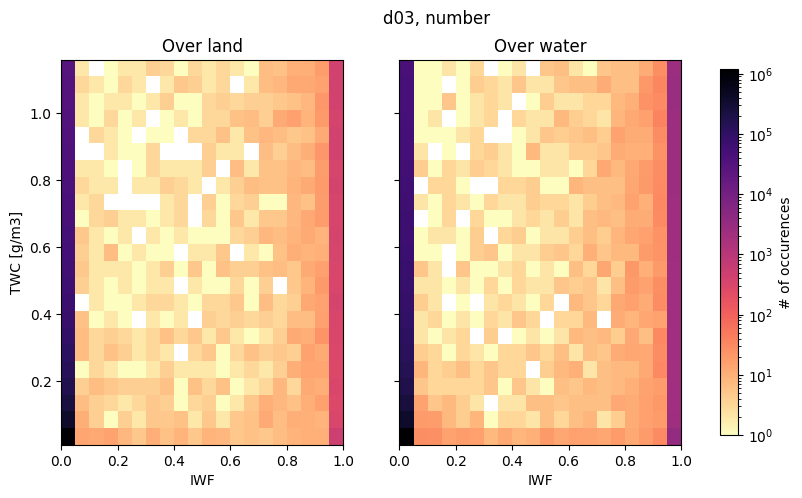

In [7]:
def hist_TWC(data, mass=True, t=slice(0, 30)):
    fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
    # Over land

    IWF = iwf_calc(data, mass=mass, t=t)
    TWC = all_ice(data, t=t, mass=mass) + all_liquid(data, t=t, mass=mass)

    X = np.nan_to_num((IWF * lndmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((TWC * lndmsk(data)).to_numpy().ravel())

    plot = ax[0].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
    np.arange(0.01, 1.2, 0.05)], cmap='magma_r')
    ax[0].set_xlabel('IWF')
    ax[0].set_title('Over land')
    cbar = fig.colorbar(plot[3], ax=ax.ravel().tolist(), shrink=0.95, label='# of occurences')

    # Over water
    X = np.nan_to_num((IWF * wtrmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((TWC  * wtrmsk(data)).to_numpy().ravel())
    plot = ax[1].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
                                                            np.arange(0.01, 1.2, 0.05)], cmap='magma_r')
    ax[1].set_xlabel('IWF')
    ax[1].set_title('Over water')

    ax[0].set_ylabel('TWC [g/m3]')
    fig.suptitle(domain + ', ' + ['mass' if mass else 'number'][0])
    plt.show()

hist_TWC(Mil3, mass=False, t=slice(0, 200))

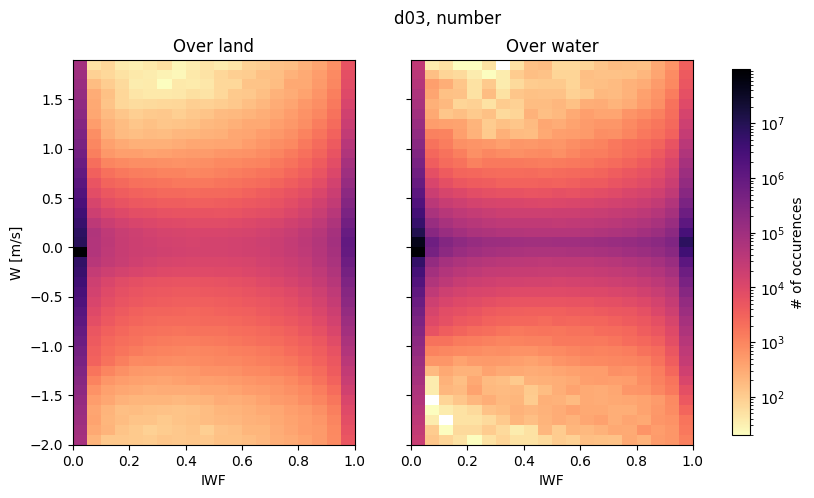

In [8]:
def hist_W(data, mass=True, t=slice(0, 30)):
    fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
    # Over land

    IWF = iwf_calc(data, mass=mass, t=t)
    W = Mil3.W.isel(Time=t) # _W(data, t=t)

    X = np.nan_to_num((IWF * lndmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((W * lndmsk(data)).to_numpy().ravel())

    plot = ax[0].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
    np.arange(-2, 2, 0.1)], cmap='magma_r')
    ax[0].set_xlabel('IWF')
    ax[0].set_title('Over land')
    cbar = fig.colorbar(plot[3], ax=ax.ravel().tolist(), shrink=0.95, label='# of occurences')

    #bins=[[0, 0.05, 0.5, 0.95, 1.001]

    # Over water
    X = np.nan_to_num((IWF.isel(Time=t) * wtrmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((W * wtrmsk(data)).to_numpy().ravel())
    plot = ax[1].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
                                                            np.arange(-2, 2, 0.1)], cmap='magma_r')
    ax[1].set_xlabel('IWF')
    ax[1].set_title('Over water')
    #cbar = fig.colorbar(plot[3], ax=ax.ravel().tolist(), shrink=0.95)
    fig.suptitle(domain + ', ' + ['mass' if mass else 'number'][0])
    ax[0].set_ylabel('W [m/s]')
    plt.show()

hist_W(Mil3, mass=False, t=slice(0, 200))

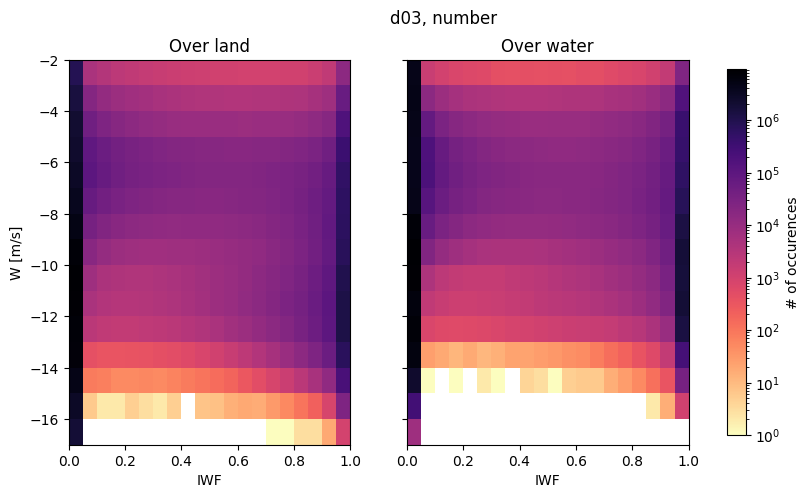

In [9]:
def hist_T(data, mass=True, t=slice(0, 30)):
    fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
    # Over land

    IWF = iwf_calc(data, mass=mass, t=t)
    T = _T(data, t=t)

    X = np.nan_to_num((IWF * lndmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((T * lndmsk(data)).to_numpy().ravel())
    plot = ax[0].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
    np.arange(-17, -1, 1)], cmap='magma_r')
    ax[0].set_xlabel('IWF')
    ax[0].set_title('Over land')
    cbar = fig.colorbar(plot[3], ax=ax.ravel().tolist(), shrink=0.95, label='# of occurences')

    #bins=[[0, 0.05, 0.5, 0.95, 1.001]

    # Over water
    X = np.nan_to_num((IWF * wtrmsk(data)).to_numpy().ravel())
    Y = np.nan_to_num((T * wtrmsk(data)).to_numpy().ravel())
    plot = ax[1].hist2d(X, Y, norm=mpl.colors.LogNorm(), bins=[np.arange(0, 1.01, 0.05), 
                                                            np.arange(-17, -1, 1)], cmap='magma_r')
    ax[1].set_xlabel('IWF')
    ax[1].set_title('Over water')
    #cbar = fig.colorbar(plot[3], ax=ax.ravel().tolist(), shrink=0.95)
    fig.suptitle(domain + ', ' + ['mass' if mass else 'number'][0])
    ax[0].set_ylabel('W [m/s]')
    plt.show()
hist_T(Mil3, mass=False, t=slice(0, 200))

## PDF's

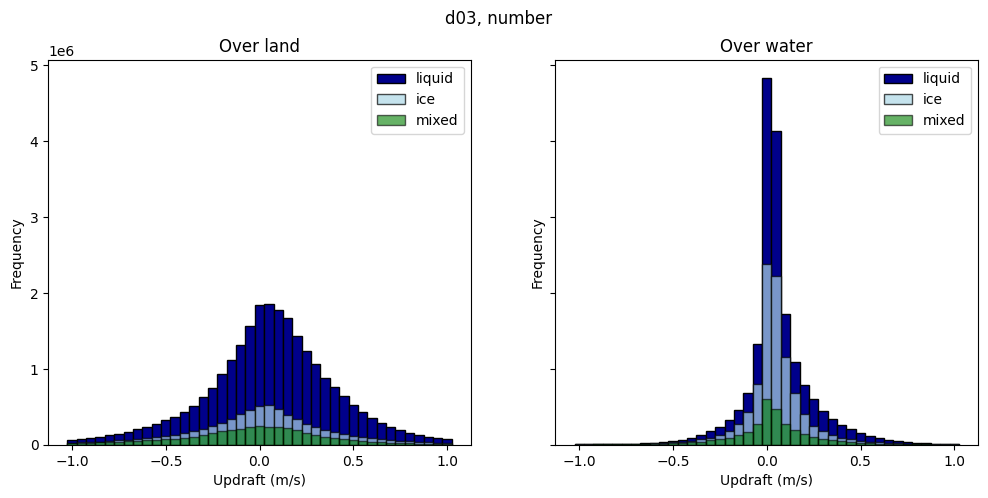

In [15]:
def PDF(data, input, mass=True, t=slice(0, 100), density=False):
    fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

    IWF = iwf_calc(data, mass=mass, t=t, cld_thrsh=0.1)

    if input == 'T':
        input = _T(data, t=t)
        ax[0].set_xlabel('Temperature (C)'); ax[1].set_xlabel('Temperature (C)')
        bins = np.arange(start=-16, stop=-2, step=0.5)
    
    elif input == 'W':
        input = _W(data, t=t)
        IWF = IWF.isel(bottom_top = slice(0, -1))
        ax[0].set_xlabel('Updraft (m/s)'); ax[1].set_xlabel('Updraft (m/s)')
        #bins = list(np.arange(-1, -0.04, 0.05)) + list(np.arange(0.05, 1, 0.05))
        bins = np.arange(-1.025, 1.026, 0.05)
        #ax[0].set_ylim([0, 0.8E6])
    
    LIQUID, MIXED, ICE = composition_msk(data, thrsh=0.05, iwf=IWF)


    ax[0].hist((LIQUID * lndmsk(data) * input).to_numpy().ravel(), alpha=1, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    ax[0].hist((ICE * lndmsk(data) * input).to_numpy().ravel(), alpha=0.7, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    ax[0].hist((MIXED * lndmsk(data) * input).to_numpy().ravel(), alpha=0.6, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    ax[0].set_title('Over land')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()

    ax[1].hist((LIQUID * wtrmsk(data) * input).to_numpy().ravel(), alpha=1, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    ax[1].hist((ICE * wtrmsk(data) * input).to_numpy().ravel(), alpha=0.7, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    ax[1].hist((MIXED * wtrmsk(data) * input).to_numpy().ravel(), alpha=0.6, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    ax[1].set_title('Over water')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    fig.suptitle(domain + ', ' + ['mass' if mass else 'number'][0])
    plt.show()
PDF(Mil3, 'W', mass=False, t=slice(0, 200), density=False)

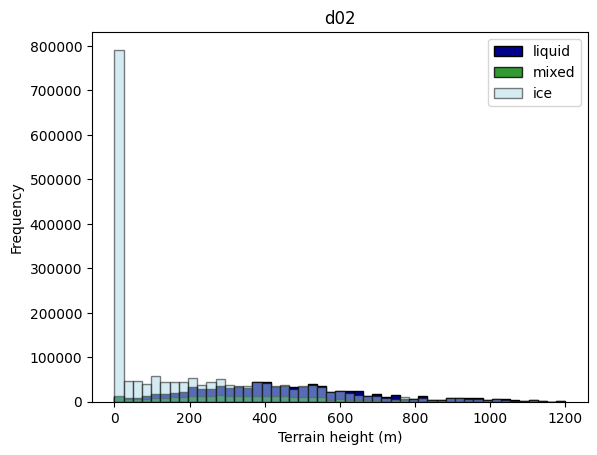

In [ ]:
H = Mil3.HGT.isel(Time=1)

bins = np.linspace(0, 1200, 50)
((LIQUID.isel(Time=t) * lndmsk(Mil3)) * H).plot(alpha=1, label='liquid', edgecolor='k', color='#00008B', bins=bins)
((MIXED.isel(Time=t) * lndmsk(Mil3)) * H).plot(alpha=0.8, label='mixed', edgecolor='k', color='g', bins=bins)
((ICE.isel(Time=t) * lndmsk(Mil3)) * H).plot(alpha=0.5, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
plt.title('Phase vs terrain height (over land)')
plt.xlabel('Terrain height (m)')
plt.ylabel('Frequency')
plt.title(domain)
plt.legend()

## Average cloud cover

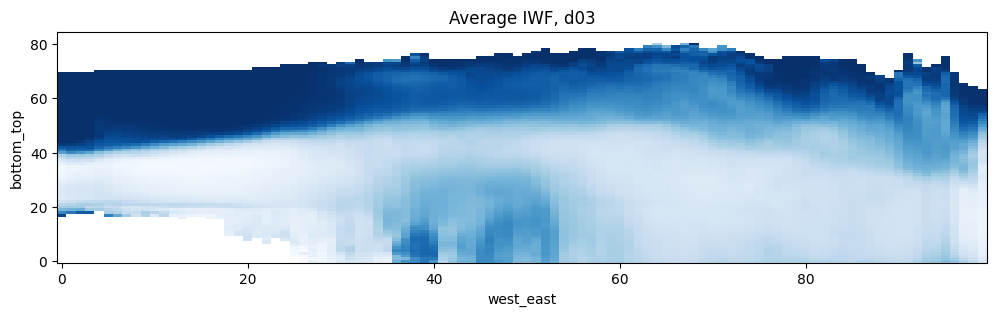

In [5]:
IWF.mean(dim=['south_north', 'Time']).plot(cmap='Blues', add_colorbar=False, label='mixed', figsize=(12,3))
#LIQUID.isel(Time=99, south_north=50).plot(cmap='Blues', add_colorbar=False, label='liquid')
#ICE.isel(Time=99, south_north=50).plot(cmap='Reds', add_colorbar=False, label='ice')
plt.title('Average IWF, ' + domain)
plt.show()

In [6]:
H.mean(dim=['south_north']).plot(c='brown', figsize=(12,3))
plt.title('Average terrain')


NameError: name 'H' is not defined

In [84]:
TNO_L = (MIXED * LANDMASK).count() + (LIQUID * LANDMASK).count() + (ICE * LANDMASK).count()
TNO_L = (MIXED * WATERMASK).count() + (LIQUID * WATERMASK).count() + (ICE * WATERMASK).count()

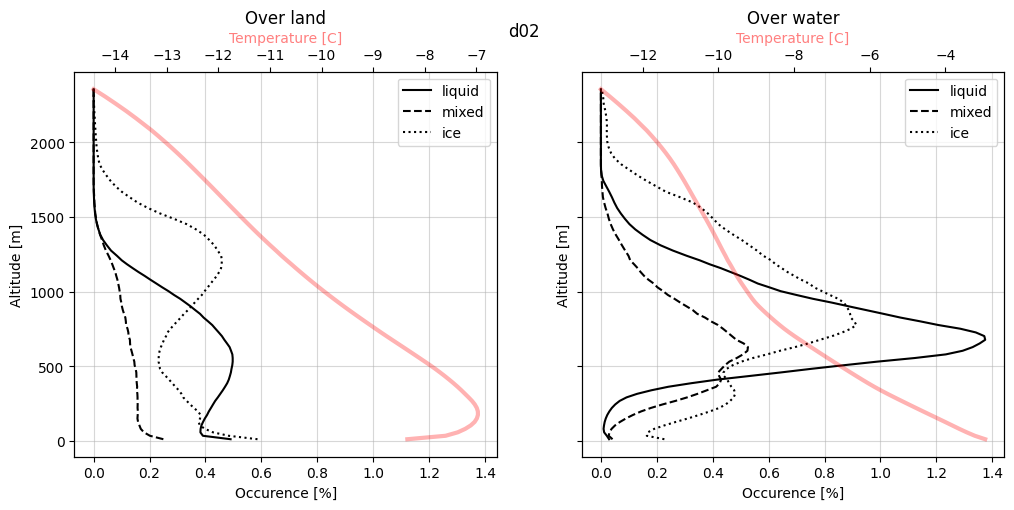

In [95]:
upto = 80
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5), sharex=True)
h = wrf.getvar(nc.Dataset(Milbrandt2), 'z')[:upto, 10,10]
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)

axT = ax[0].twiny()
T_mean = (T * LANDMASK).isel(bottom_top=slice(0, upto)).mean(dim=['west_east', 'south_north', 'Time'])
axT.plot(T_mean, h, label='Lapse rate', color='r', alpha=0.3, linewidth=3)
axT.set_xlabel('Temperature [C]', color='red', alpha=0.5)

ax[0].plot((LIQUID*LANDMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100, h, c='k', label='liquid')
ax[0].plot((MIXED*LANDMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100,  h, c='k', linestyle='dashed', label='mixed')
ax[0].plot((ICE*LANDMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100, h, c='k', linestyle='dotted', label='ice')
ax[0].set_xlabel('Occurence [%]')
ax[0].set_ylabel('Altitude [m]')
ax[0].set_title('Over land')


axT = ax[1].twiny()
T_mean = (T*WATERMASK).isel(bottom_top=slice(0, upto)).mean(dim=['west_east', 'south_north', 'Time'])
axT.plot(T_mean, h, label='Lapse rate', color='r', alpha=0.3, linewidth=3)
axT.set_xlabel('Temperature [C]', color='red', alpha=0.5)

ax[1].plot((LIQUID*WATERMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100,  h, c='k', label='liquid')
ax[1].plot((MIXED*WATERMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100,  h, c='k', linestyle='dashed', label='mixed')
ax[1].plot((ICE*WATERMASK).isel(bottom_top=slice(0, upto)).sum(dim=['Time', 'west_east', 'south_north'])/TNO_L*100,  h, c='k', linestyle='dotted', label='ice')
ax[1].set_xlabel('Occurence [%]')
ax[1].set_ylabel('Altitude [m]')
ax[1].set_title('Over water')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
fig.suptitle(domain)
plt.show()

del T_mean, h, fig, ax, axT

## Clustering

In [20]:
#MIXED_test = MIXED.isel(Time=99, south_north=50)
#LIQUID_test = LIQUID.isel(Time=99, south_north=50)
#ICE_test = ICE.isel(Time=99, south_north=50)

In [21]:
#MIXED_test_points = np.where(MIXED_test.to_numpy() == 1)
#MIXED_test_points = np.column_stack([MIXED_test_points[0], MIXED_test_points[1]])

In [22]:
#clusters = cluster.DBSCAN(eps=5)

In [23]:
#labels = clusters.fit_predict(MIXED_test_points)

In [24]:
#plt.scatter(MIXED_test_points[:,1], MIXED_test_points[:,0], c=labels)

# Cloud top

Temp, W, ICNC - one only QICE, then plus snow and graupel, TWC

Weighted mean for IWF based on TWC [How does that work when Liquid is already 0? How to weight zeros?]

### CT plots

In [3]:
CLOUDTOP = find_top(MD3, MorrisonDefault3, cld_thrsh=0.5, t=slice(0, -1))

In [5]:
IWF_TOP = select_top(iwf_calc(MD3, mass=True, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])
T_TOP = select_top(calc_T(MD3, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])
W_TOP = select_top(calc_W(MD3, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])

In [7]:
def plot_CT(t, data=Mil3):
    CLOUDTOP = find_top(MD3, MorrisonDefault3, cld_thrsh=0.5, t=slice(0, -1))
    IWF_TOP = select_top(iwf_calc(MD3, mass=True, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])
    T_TOP = select_top(calc_T(MD3, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])
    W_TOP = select_top(calc_W(MD3, t=slice(0, -1)), CLOUDTOP, n_levels=10).mean(dim=['bottom_top'])

    proj = ccrs.NorthPolarStereo(11.1)
    fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14, 5), subplot_kw={'projection':proj})
    time = data.XTIME.isel(Time=t).dt.strftime('%y-%m-%d %H:%M').to_numpy()
    fig.suptitle(f'Cloud-top {domain}, upper 10, t={time}')

    
    IWF_TOP.isel(Time=t).plot(x='XLONG', y='XLAT', transform=ccrs.PlateCarree(), ax=ax[0], 
    levels=np.arange(0, 1.11, 0.1), cmap='coolwarm', 
    cbar_kwargs={'label': 'Fraction', 'orientation': 'horizontal'})
    ax[0].set_title(f'Cloud-top Ice Water Fraction')

    T_TOP.isel(Time=t).plot(x='XLONG', y='XLAT', transform=ccrs.PlateCarree(), ax=ax[1], 
    levels=np.arange(-16, -7, 1), cmap='coolwarm',
    cbar_kwargs={'label': 'deg C', 'orientation': 'horizontal'})
    ax[1].set_title(f'Cloud-top Temperature')

    h = select_top(wrf.getvar(nc.Dataset(Milbrandt3), 'z'), 
                   CLOUDTOP.isel(Time=t), n_levels=1).sum(dim='bottom_top')
    h.plot(x='XLONG', y='XLAT', transform=ccrs.PlateCarree(), ax=ax[2], 
    levels=[5] + list(np.arange(250, 2250, 250)), cmap='viridis', extend='max',
    cbar_kwargs={'label': 'm', 'orientation': 'horizontal'})
    ax[2].set_title(f'Cloud-top height')

    (W_TOP.isel(Time=t) * 100).plot(x='XLONG', y='XLAT', transform=ccrs.PlateCarree(), ax=ax[3], extend='both',
    levels=np.arange(-45, 50, 10), cmap='bwr', cbar_kwargs={'label': 'cm/s', 'orientation': 'horizontal'})
    ax[3].set_title(f'Cloud-top Updraft')
    plt.tight_layout()

    for x in ax:
        x.coastlines()
        x.gridlines()
        x.scatter(y=78.923538, x=11.909895, transform=ccrs.PlateCarree(), linewidth=3, color='k', marker='x')


    return fig

In [8]:
plot_CT(t=1)
plt.show()

ValueError: operands could not be broadcast together with shapes (231,84,90,90) (84,100,100) 

In [18]:
animate(plot_CT, data=MD3, anim_title='MorrisonDefault_CTAnimation', n_timesteps=230)

100%|██████████| 230/230 [05:19<00:00,  1.39s/it]


### CT Stats

In [14]:
_IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=slice(0, 100))
print('Cloud Top stats BEFORE t=12/11 13:00')
print_stats(
    xr.where(_IWF_TOP > 0.95, x=_IWF_TOP, y=np.nan), 
    xr.where((_IWF_TOP < 0.95) 
    & (_IWF_TOP > 0.05), x=_IWF_TOP, y=np.nan), 
    xr.where(_IWF_TOP < 0.05, x=_IWF_TOP, y=np.nan),
    _IWF_TOP)


print('--------------------------')
_IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=slice(100, -1))
print('Cloud Top stats AFTER t=12/11 13:00')
print_stats(
    xr.where(_IWF_TOP > 0.95, x=_IWF_TOP, y=np.nan), 
    xr.where((_IWF_TOP < 0.95) 
    & (_IWF_TOP > 0.05), x=_IWF_TOP, y=np.nan), 
    xr.where(_IWF_TOP < 0.05, x=_IWF_TOP, y=np.nan),
    _IWF_TOP)
del _IWF_TOP

Cloud Top stats BEFORE t=12/11 14:00
Over land:
Ice:  733723 ,  15.97 %
Mixed:  771701 ,  16.79 %
Liquid:  3090199 ,  67.24 %
Over water:
Ice:  612846 ,  11.85 %
Mixed:  287870 ,  5.57 %
Liquid:  4270488 ,  82.58 %
--------------------------
Cloud Top stats AFTER t=12/11 14:00
Over land:
Ice:  3407818 ,  55.89 %
Mixed:  1108992 ,  18.19 %
Liquid:  1580322 ,  25.92 %
Over water:
Ice:  5583377 ,  87.88 %
Mixed:  192833 ,  3.04 %
Liquid:  576878 ,  9.08 %


In [15]:
def calc_precentages(iwf):
    ice = float(xr.where(iwf > 0.95, x=1, y=np.nan).count() / (iwf).count()) * 100
    mixed = float(xr.where((iwf < 0.95) & (iwf > 0.05), x=1, y=np.nan).count() / (iwf).count()) * 100
    liquid = float(xr.where(iwf < 0.05, x=1, y=np.nan).count() / (iwf).count()) * 100
    return [liquid, mixed, ice]

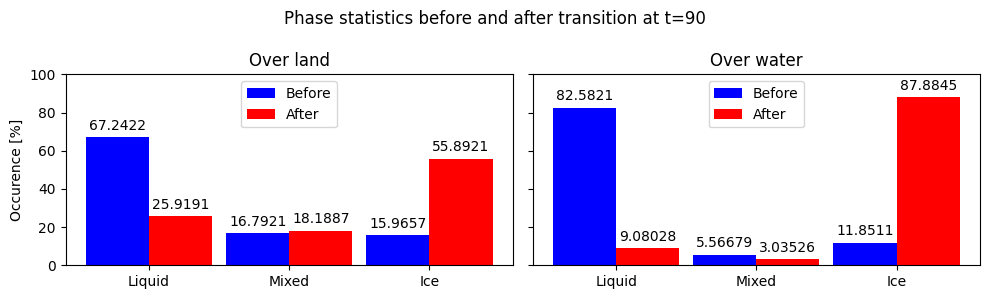

In [16]:
t_split = 100

x = np.array([1, 2, 3])
width = 0.45

IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10)

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
rects1 = ax[0].bar(x - width/2, calc_precentages(IWF_TOP.isel(Time=slice(0, t_split)) * LANDMASK), width, label='Before', color='blue')
rects2 = ax[0].bar(x + width/2, calc_precentages(IWF_TOP.isel(Time=slice(t_split, -1)) * LANDMASK), width, label='After', color='red')

ax[0].set_ylabel('Occurence [%]')
ax[0].set_title('Over land')
ax[0].set_xticks(x, ['Liquid', 'Mixed', 'Ice'])
ax[0].legend(loc='upper center')

ax[0].bar_label(rects1, padding=3)
ax[0].bar_label(rects2, padding=3)

rects1 = ax[1].bar(x - width/2, calc_precentages(IWF_TOP.isel(Time=slice(0, t_split)) * WATERMASK), width, label='Before', color='blue')
rects2 = ax[1].bar(x + width/2, calc_precentages(IWF_TOP.isel(Time=slice(t_split, -1)) * WATERMASK), width, label='After', color='red')
ax[1].set_ylim(0, 100)
ax[1].set_title('Over water')
ax[1].set_xticks(x, ['Liquid', 'Mixed', 'Ice'])
ax[1].legend(loc='upper center')

ax[1].bar_label(rects1, padding=3)
ax[1].bar_label(rects2, padding=3)


fig.suptitle('Phase statistics before and after transition at t=90')
fig.tight_layout()
plt.show()
del IWF_TOP

### CT Histograms and PDF

MemoryError: Unable to allocate 1.47 GiB for an array with shape (232, 85, 100, 100) and data type float64

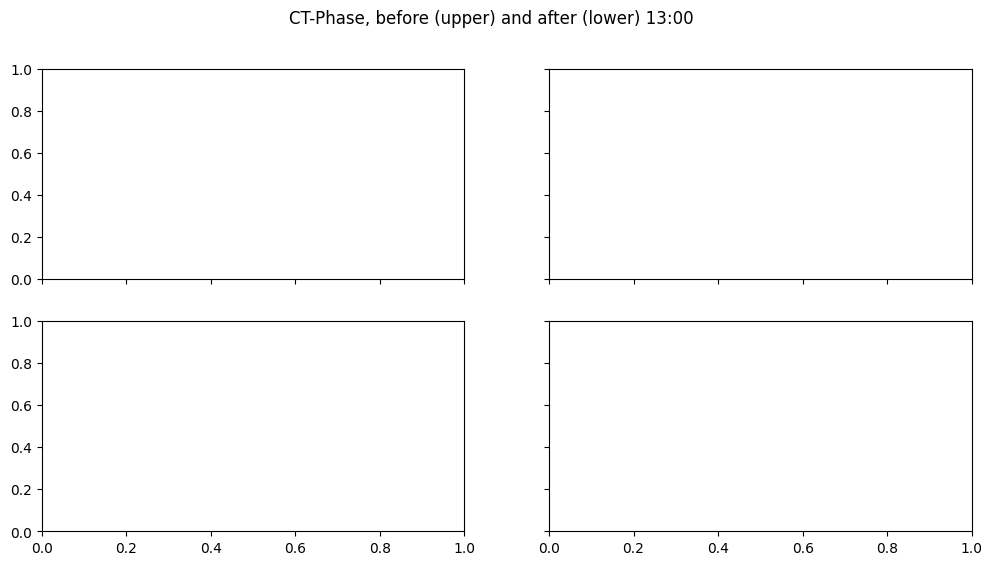

In [27]:
def hist_plot(mean=True, density=False):
    bins = np.arange(start=-15, stop=0, step=0.1)

    fig, ax = plt.subplots(2, 2, figsize=(12,6), sharey=True, sharex=True)
    fig.suptitle('CT-Phase, before (upper) and after (lower) 13:00')

    ################# Before
    time_slice = slice(0, 100)

    # Without mean:
    IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    T_TOP = select_top(T, CLOUDTOP, n_levels=10).isel(Time=time_slice)

    if mean:
        IWF_TOP = IWF_TOP.mean(dim='bottom_top')
        T_TOP = T_TOP.mean(dim='bottom_top')
        fig.suptitle('CT-Phase (mean), before (upper) and after (lower) 13:00')

    MIXED_TOP = xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan)
    ax[0, 0].hist((MIXED_TOP * LANDMASK * T_TOP).to_numpy().ravel(),
                    alpha=1, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    ax[0, 1].hist((MIXED_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=1, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    del MIXED_TOP

    LIQUID_TOP = xr.where(IWF_TOP < 0.05, x=1, y=np.nan)
    ax[0, 0].hist((LIQUID_TOP * LANDMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.5, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    ax[0, 1].hist((LIQUID_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.5, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    del LIQUID_TOP

    ICE_TOP = xr.where(IWF_TOP > 0.95, x=1, y=np.nan)
    ax[0, 0].hist((ICE_TOP * LANDMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.4, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    ax[0, 1].hist((ICE_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.4, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    del ICE_TOP

    ax[0, 0].set_title('Over land')
    ax[0, 0].set_ylabel('Occurences')
    ax[0, 0].legend()

    ax[0, 1].set_title('Over water')
    ax[0, 1].legend()


    ################# After
    time_slice = slice(100, -1)
    
    IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    T_TOP = select_top(T, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    
    if mean:
        IWF_TOP = IWF_TOP.mean(dim='bottom_top')
        T_TOP = T_TOP.mean(dim='bottom_top')
        fig.suptitle('CT-Phase (mean), before (upper) and after (lower) 13:00')

    MIXED_TOP = xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan)
    ax[1, 0].hist((MIXED_TOP * LANDMASK * T_TOP).to_numpy().ravel(), 
                    alpha=1, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    ax[1, 1].hist((MIXED_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=1, density=density, label='mixed', edgecolor='k', color='g', bins=bins)
    del MIXED_TOP

    LIQUID_TOP = xr.where(IWF_TOP < 0.05, x=1, y=np.nan)
    ax[1, 0].hist((LIQUID_TOP * LANDMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.5, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    ax[1, 1].hist((LIQUID_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.5, density=density, label='liquid', edgecolor='k', color='#00008B', bins=bins)
    del LIQUID_TOP

    ICE_TOP = xr.where(IWF_TOP > 0.95, x=1, y=np.nan)
    ax[1, 0].hist((ICE_TOP * LANDMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.4, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    ax[1, 1].hist((ICE_TOP * WATERMASK * T_TOP).to_numpy().ravel(), 
                    alpha=0.4, density=density, label='ice', edgecolor='k', color='#ADD8E6', bins=bins)
    del ICE_TOP

    ax[1, 0].set_xlabel('Temperature (C)')
    ax[1, 0].set_ylabel('Occurences')
    ax[1, 0].legend()

    ax[1, 1].set_xlabel('Temperature (C)')
    ax[1, 1].legend()

    plt.show()
    del IWF_TOP, T_TOP
hist_plot(mean=False, density=True)

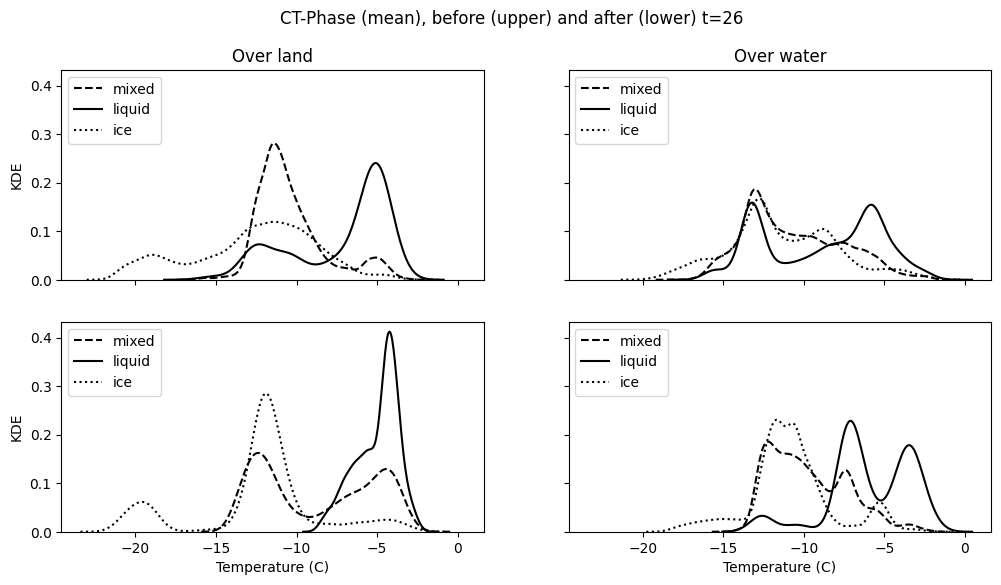

In [207]:
def KDE_plot(mean=True):
    bins = np.arange(start=-15, stop=0, step=0.1)

    fig, ax = plt.subplots(2, 2, figsize=(12,6), sharey=True, sharex=True)
    fig.suptitle('CT-Phase, before (upper) and after (lower) t=26')

    ################# Before
    time_slice = slice(0, 26)
    IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    T_TOP = select_top(T, CLOUDTOP, n_levels=10).isel(Time=time_slice)

    if mean:
        IWF_TOP = IWF_TOP.mean(dim='bottom_top')
        T_TOP = T_TOP.mean(dim='bottom_top')
        fig.suptitle('CT-Phase (mean), before (upper) and after (lower) t=26')

    MIXED_TOP = (xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(MIXED_TOP[~np.isnan(MIXED_TOP)], ax=ax[0,0], color='k', linestyle='dashed', label='mixed')
    MIXED_TOP = (xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(MIXED_TOP[~np.isnan(MIXED_TOP)], ax=ax[0,1], color='k', linestyle='dashed', label='mixed')
    del MIXED_TOP

    LIQUID_TOP = (xr.where(IWF_TOP < 0.05, x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(LIQUID_TOP[~np.isnan(LIQUID_TOP)], ax=ax[0,0], color='k', linestyle='solid', label='liquid')
    LIQUID_TOP = (xr.where(IWF_TOP < 0.05, x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(LIQUID_TOP[~np.isnan(LIQUID_TOP)], ax=ax[0,1], color='k', linestyle='solid', label='liquid')
    del LIQUID_TOP

    ICE_TOP = (xr.where(IWF_TOP > 0.95, x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(ICE_TOP[~np.isnan(ICE_TOP)], ax=ax[0,0], color='k', linestyle='dotted', label='ice')
    ICE_TOP = (xr.where(IWF_TOP > 0.95, x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(ICE_TOP[~np.isnan(ICE_TOP)], ax=ax[0,1], color='k', linestyle='dotted', label='ice')
    del ICE_TOP


    ################# After
    time_slice = slice(26, -1)

    IWF_TOP = select_top(IWF, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    T_TOP = select_top(T, CLOUDTOP, n_levels=10).isel(Time=time_slice)
    if mean:
        IWF_TOP = IWF_TOP.mean(dim='bottom_top')
        T_TOP = T_TOP.mean(dim='bottom_top')

    MIXED_TOP = (xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(MIXED_TOP[~np.isnan(MIXED_TOP)], ax=ax[1,0], color='k', linestyle='dashed', label='mixed')
    MIXED_TOP = (xr.where((IWF_TOP > 0.05) & (IWF_TOP < 0.95), x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(MIXED_TOP[~np.isnan(MIXED_TOP)], ax=ax[1,1], color='k', linestyle='dashed', label='mixed')
    del MIXED_TOP

    LIQUID_TOP = (xr.where(IWF_TOP < 0.05, x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(LIQUID_TOP[~np.isnan(LIQUID_TOP)], ax=ax[1,0], color='k', linestyle='solid', label='liquid')
    LIQUID_TOP = (xr.where(IWF_TOP < 0.05, x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(LIQUID_TOP[~np.isnan(LIQUID_TOP)], ax=ax[1,1], color='k', linestyle='solid', label='liquid')
    del LIQUID_TOP

    ICE_TOP = (xr.where(IWF_TOP > 0.95, x=1, y=np.nan) * LANDMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(ICE_TOP[~np.isnan(ICE_TOP)], ax=ax[1,0], color='k', linestyle='dotted', label='ice')
    ICE_TOP = (xr.where(IWF_TOP > 0.95, x=1, y=np.nan) * WATERMASK * T_TOP).to_numpy().ravel()
    sns.kdeplot(ICE_TOP[~np.isnan(ICE_TOP)], ax=ax[1,1], color='k', linestyle='dotted', label='ice')
    del ICE_TOP

    ax[1, 1].set_xlabel('Temperature (C)')
    ax[1, 0].set_xlabel('Temperature (C)')
    ax[0, 0].set_ylabel('KDE')
    ax[1, 0].set_ylabel('KDE')
    ax[0, 0].legend(loc='upper left'); ax[1, 0].legend(loc='upper left')
    ax[1, 1].legend(loc='upper left'); ax[0, 1].legend(loc='upper left')
    ax[0, 0].set_title('Over land')
    ax[0, 1].set_title('Over water')

    plt.show()
KDE_plot(mean=True)

### CT Phase segments

In [21]:
Mil2C = clip_to_region(Mil2, Milbrandt2, clip_to_data=Milbrandt3)

In [4]:
IWF = select_top(iwf_calc(MD3, mass=True, cld_thrsh=0.5), 
                 find_top(MD3, MorrisonDefault3, cld_thrsh=0.5), 
                 n_levels=7).mean(dim='bottom_top')
IWF_masked = xr.where(IWF > 0.9, x = 1, y = IWF)
IWF_masked = xr.where(IWF_masked <= 0.1, x = 0, y = IWF_masked)
IWF_masked = xr.where((IWF_masked > 0.1) & (IWF_masked < 0.9), x = 0.5, y = IWF_masked)

#CTL = find_top(Mil3, Milbrandt3, cld_thrsh=0.5)
#wind = wrf.getvar(nc.Dataset(Milbrandt3), "wspd", units="m s-1", timeidx=wrf.ALL_TIMES)

In [28]:
#IWF_maskedC = clip_to_region(IWF_masked, Milbrandt2, clip_to_data=Milbrandt3)
#CTLC = clip_to_region(CTL, Milbrandt2, clip_to_data=Milbrandt3)
#windC = clip_to_region(wind, Milbrandt2, clip_to_data=Milbrandt3)

In [3]:
import time
class timer:
    def __init__(self):
        self._start_time = None
        self._round_time = None

    def start(self):
        self._start_time = time.perf_counter()

    def round(self):
        if self._round_time is None:
            t = time.perf_counter() - self._start_time
            self._round_time = time.perf_counter()
        else:
            t = time.perf_counter() - self._round_time
            self._round_time = time.perf_counter()
        return f'Elapsed time: {t:0.4f} seconds'
    
    def stop(self):
        t = time.perf_counter() - self._start_time
        self._start_time = None
        self._round_time = None
        return f'Elapsed time: {t:0.4f} seconds.'


In [37]:
def consecutive(arr):
    return np.split(arr, np.where(np.diff(arr) != 1)[0] + 1)


def segment_lengths(data, datapath, n_points=100, condition='IWF > 0.5', mass=True, 
                    n_levels=7, cld_thrsh=0.5, IWF_masked=None, CTL=None, wind=None, 
                    from_time=0, to_time=-1):
    '''Find length of consecutive phase segements'''

    #if wind is None:
    #    print('Getting wind')
    #    wind = wrf.getvar(nc.Dataset(datapath), "wspd", units="m s-1", 
    #                      timeidx=wrf.ALL_TIMES).isel(Time=slice(from_time, to_time))
    #    print('Done')
    #else:
    #    wind = wind.isel(Time=slice(from_time, to_time))

    t = timer()
    t.start()
    if CTL is None:
        print('Getting Cloud-Top...')
        CTL = find_top(data, datapath, cld_thrsh=cld_thrsh, t=slice(from_time, to_time))
        print(f'Done. {t.round()}')
    else:
        CTL = CTL.isel(Time=slice(from_time, to_time))

    if IWF_masked is None:
        print('Getting IWF...')
        IWF_masked = select_top(iwf_calc(data, mass=mass, cld_thrsh=cld_thrsh, t=slice(from_time, to_time)), 
                                find_top(data, datapath, cld_thrsh=cld_thrsh, t=slice(from_time, to_time)), 
                                n_levels=n_levels).mean(dim='bottom_top')

        IWF_masked = xr.where(IWF_masked > 0.9, x = 1, y = IWF_masked)
        IWF_masked = xr.where(IWF_masked <= 0.1, x = 0, y = IWF_masked)
        IWF_masked = xr.where((IWF_masked > 0.1) & (IWF_masked < 0.9), x = 0.5, y = IWF_masked)
        print(f'Done. {t.round()}')
    else:
        IWF_masked = IWF_masked.isel(Time=slice(from_time, to_time))

    x_shape, y_shape = len(data.west_east), len(data.south_north)
    if n_points is None:
        n_points = x_shape * y_shape

    print('Getting wind...')
    winds = [wrf.getvar(nc.Dataset(datapath), "wspd", units="m s-1", timeidx=200 + t) for t in range(0, 220)]
    print(f'Done. {t.round()}')

    def f(i):
        x, y = int(np.floor(i / x_shape)), int(i % y_shape) #translate to x, y

        xy_IWF = IWF_masked.isel(south_north=y, west_east=x)
        P = np.where(eval('xy_IWF' + condition))[0]
        segment = consecutive(P)
        
        lengths = []
        for e in segment:
            length = 0
            for timeidx in e:
                H = int(CTL.isel(Time=timeidx, south_north=y, west_east=x))
                wspd = float(winds[timeidx].isel(bottom_top=H, south_north=y, west_east=x))
                #wind = wrf.getvar(nc.Dataset(datapath), "wspd", units="m s-1", timeidx=200 + timeidx)
                #wspd = float(wind.isel(bottom_top=H, south_north=y, west_east=x))
                length += wspd * 5 * 60 # m/s * 5min timestep = meters
            lengths.append(length)
        return np.array(lengths)

    set_loky_pickler()
    with tqdm_joblib('Progress', total=n_points) as progress_bar:
        res = Parallel(n_jobs=8)(delayed(f)(i) for i in range(n_points))


    # Create data set of mean lengths, total lengths
    DA_mean = np.zeros((x_shape, y_shape))
    DA_total = np.zeros((x_shape, y_shape))
    DA_nsegments = np.zeros((x_shape, y_shape))

    for i in range(n_points):
        x, y = int(np.floor(i / x_shape)), int(i % y_shape)
        DA_mean[x, y] = res[i].mean()
        DA_total[x, y] = res[i].sum()
        DA_nsegments[x, y] = len(res[i])

    if condition[0] == '=':
        description = 'Mixed-phase segment stats'
    else:
        description = ['Liquid segment stats' if condition[0] == '<' else 'Ice segment stats']
    
    DA = xr.Dataset(data_vars=dict(
            MEAN = (['west_east', 'south_north'], DA_mean),
            TOTAL = (['west_east', 'south_north'], DA_total),
            N_SEGMENTS = (['west_east', 'south_north'], DA_nsegments)
        ),
        attrs = dict(
            description=description, units='m', 
            #start = data.XTIME.isel(Time=from_time).dt.strftime('%y-%m-%d %H:%M').to_numpy(),
            #end = data.XTIME.isel(Time=to_time).dt.strftime('%y-%m-%d %H:%M').to_numpy()
            start = datetime(year=2019, month=11, day=12, hour=4, minute=40),
            end = datetime(year=2019, month=11, day=12, hour=23, minute=0)
        )
    )

    DA.coords['lon'] = data.XLONG.isel(Time=0)
    DA.coords['lat'] = data.XLAT.isel(Time=0)
    
    return res, DA #calculations

In [5]:
#MD_res, MD_DA = segment_lengths(MD3, MorrisonDefault3, n_points=None, condition='== 0.5', cld_thrsh=0.5, 
#                      from_time=0, to_time=220)

Getting Cloud-Top...
Done. Elapsed time: 40.0142 seconds
Getting IWF...
Done. Elapsed time: 30.9567 seconds
Getting wind...
Done. Elapsed time: 103.3581 seconds


100%|██████████| 10000/10000 [30:01<00:00,  5.55it/s]


In [57]:
MD_DA = xr.open_dataset('MorrisonDefault3_MixedTemporalSegmentsMass')
MA_DA = xr.open_dataset('MorrisonAdapted3_MixedTemporalSegmentsMass')
MAS_DA = xr.open_dataset('MorrisonAdaptedSIP3_MixedTemporalSegmentsMass')

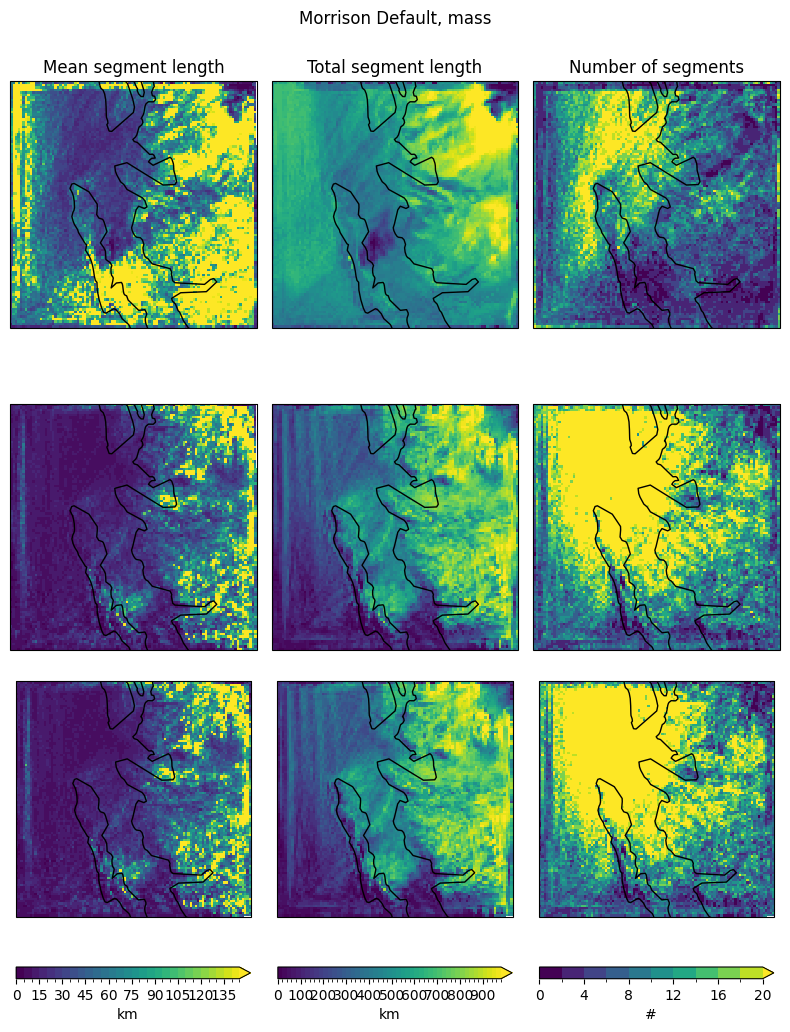

In [58]:
proj = ccrs.NorthPolarStereo(11.1)
fig, ax = plt.subplots(3, 3, figsize=(8, 10.6), sharex=True, sharey=True, subplot_kw={'projection':proj})


for i, x, da in zip(range(3), ax, [MD_DA, MA_DA, MAS_DA]):
    if i == 2:
        p1 = (da.MEAN / 1000).plot(x='lon', y='lat', transform=ccrs.PlateCarree(),
            ax=x[0], levels=np.arange(0, 150, 5), cbar_kwargs={'orientation': 'horizontal', 'shrink':0.95, 'label': 'km'})
        p2 = (da.TOTAL / 1000).plot(x='lon', y='lat', transform=ccrs.PlateCarree(),
            ax=x[1], levels=np.arange(0, 1000, 20), cbar_kwargs={'orientation': 'horizontal', 'shrink':0.95, 'label': 'km'})
        p3 = da.N_SEGMENTS.plot(x='lon', y='lat', transform=ccrs.PlateCarree(),
            ax=x[2], levels=np.arange(0, 21, 2), cbar_kwargs={'orientation': 'horizontal', 'shrink':0.95, 'label': '#'})

    else:    
        p1 = (da.MEAN / 1000).plot(x='lon', y='lat', transform=ccrs.PlateCarree(),
            ax=x[0], levels=np.arange(0, 150, 5), add_colorbar=False)
        p2 = (da.TOTAL / 1000).plot(x='lon', y='lat', transform=ccrs.PlateCarree(),
            ax=x[1], levels=np.arange(0, 1000, 20), add_colorbar=False)
        p3 = da.N_SEGMENTS.plot(x='lon', y='lat', transform=ccrs.PlateCarree(),
            ax=x[2], levels=np.arange(0, 21, 2), add_colorbar=False)

fig.suptitle('Morrison Default, mass')#, before glaciation at t=94 / {DA.end}')
for x in ax.flatten():
    x.coastlines()
    x.set_title(None)
ax[0, 0].set_title('Mean segment length')
ax[0, 1].set_title('Total segment length')
ax[0, 2].set_title('Number of segments')
fig.tight_layout()
plt.show()

### Segments spatial (along-wind)

##### Setup

In [4]:
################ Singular segment class
class Segment:
    def __init__(self, t, indices, lengths, transect, ds, wind_dir, updrafts):
        self.t = t
        self.lengths = lengths
        self.indices = indices
        self.transect = transect
        self.ds = ds
        self.n_points = len(self.transect[0])
        self.n_pockets = len(self.lengths)
        self.wind_dir = wind_dir
        self.updrafts = updrafts
        self.mean = self.lengths.mean()
        self.std = self.lengths.std()
      
    def plot_lengths(self, ax=None):
        if ax is None:
            plt.plot(np.arange(self.n_pockets), self.lengths)
            plt.xlabel('Pocket number')
            plt.ylabel('Pocket length [km]')
        ax.plot(np.arange(self.n_pockets), self.lengths, label=self.t)

    def plot_transect(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.NorthPolarStereo(11.1)})
            ax.set_extent([min(self.transect[0]), max(self.transect[0]),
                           min(self.transect[1]), max(self.transect[1])])
            ax.gridlines()
            ax.coastlines()
        ax.plot(self.transect[0], self.transect[1], label=self.t, transform=ccrs.PlateCarree(), color='red')

############## Collective class (each timestep)

class Segments:
    def __init__(self, data, t, H, wind_dir):
        self.t = t
        self.H = H
        self.wind_dir = wind_dir

        self.all_segments = []
        self.data = data

    def new_seg(self, seg):
        self.all_segments.append(seg)

    def visualize(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.NorthPolarStereo(11.1)})
            ax.set_extent([self.data.XLONG.isel(Time=1).min(), self.data.XLONG.isel(Time=1).max(),
                                self.data.XLAT.isel(Time=1).min(), self.data.XLAT.isel(Time=1).max()])
            ax.coastlines()
            ax.gridlines()
        [e.plot_transect(ax=ax) for e in self.all_segments]
  
    def all_pockets(self):
        all = []
        for S in self.all_segments:
            all += list(S.lengths)
        return np.array(all)

    def all_updrafts(self):
        all = []
        for S in self.all_segments:
            try:
                all += flatten_list(list(S.updrafts))
            except TypeError:
                all += []
        return np.array(all)
  
    @property
    def mean_updraft(self):
        return self.all_updrafts().mean()
  
    @property
    def mean(self):
        return self.all_pockets().mean()

    @property
    def total_length(self):
        L = 0
        for e in self.all_segments:
            loc1 = (e.transect[1][0], e.transect[0][0])
            loc2 = (e.transect[1][-1], e.transect[0][-1])
            L += hs.haversine(loc1, loc2)
        return L

    @property
    def n_pockets(self):
        return len(self.all_pockets())
    
######################### Helper functions

def get_ds(interline):
    n_points = len(interline)
    ds = np.zeros(n_points - 1)

    for i in range(n_points - 1):
        loc1 = (float(str(interline[i].coords['xy_loc'].to_numpy()).split('=')[-2][:-5]),
                float(str(interline[i].coords['xy_loc'].to_numpy()).split('=')[-1][:-2]))
        loc2 = (float(str(interline[i + 1].coords['xy_loc'].to_numpy()).split('=')[-2][:-5]), 
                float(str(interline[i + 1].coords['xy_loc'].to_numpy()).split('=')[-1][:-2]))
        ds[i] = hs.haversine(loc1, loc2)
    return ds.mean()

def get_coords(interline):
    n_points = len(interline)
    lats = []
    lons = []
    for i in range(n_points):
        loc1 = (float(str(interline[i].coords['xy_loc'].to_numpy()).split('=')[-1][:-2]), 
                float(str(interline[i].coords['xy_loc'].to_numpy()).split('=')[-2][:-5]))
        lats.append(loc1[1])
        lons.append(loc1[0])
    return [lons, lats]

############################ Main function
def segment_lengths_alongwind(data, datapath, condition='== 0.5', IWF_masked=None, CTL=None, 
            from_time=0, to_time=-1, mass=True, cld_thrsh=0.5, n_levels=7, phase_thrsh=0.1,
            transect_step=5, alongwind=True):
    t = timer()
    t.start()
    if CTL is None:
        print('Getting Cloud-Top...')
        CTL = find_top(data, datapath, cld_thrsh=cld_thrsh, t=slice(from_time, to_time))
        print(f'Done. {t.round()}')
        
    if IWF_masked is None:
        print('Calculating IWF...')
        IWF = select_top(iwf_calc(data, mass=mass, cld_thrsh=cld_thrsh, t=slice(from_time, to_time)), 
                 CTL.isel(Time=slice(from_time, to_time)), 
                 n_levels=n_levels).mean(dim='bottom_top')
        IWF_masked = xr.where(IWF > 1 - phase_thrsh, x = 1, y = IWF)
        IWF_masked = xr.where(IWF_masked <= phase_thrsh, x = 0, y = IWF_masked)
        IWF_masked = xr.where((IWF_masked > phase_thrsh) & (IWF_masked < 1 - phase_thrsh), x = 0.5, y = IWF_masked)
        print(f'Done. {t.round()}')

    def ff(t):
        H = int(CTL.isel(Time=t).mean())
        ncdata = nc.Dataset(datapath)

        wind_dir = int(wrf.getvar(ncdata, 'wdir', timeidx=t).isel(bottom_top=H).mean())
        addx, addy = 0, 99
        if not alongwind:
            addx, addy = 0, 0
            wind_dir -= 90
            if wind_dir < 0:
                wind_dir = 360 + wind_dir

        info = [t, H, wind_dir]
        transects = []
        for i in range(15, 86, transect_step):
            lat, lon = wrf.xy_to_ll(ncdata, x = abs(addx - i), y = abs(addy - i))
            pivot_point = wrf.CoordPair(lat=lat, lon=lon)
            
            interline = wrf.interpline(IWF_masked.isel(Time=t), wrfin=nc.Dataset(datapath), 
                        pivot_point=pivot_point, angle=wind_dir, latlon=True, meta=True)

            ds = get_ds(interline)
            
            phase_interline = np.where(eval('interline.to_numpy()' + condition))[0]
            indices = consecutive(phase_interline)
            trans_coords = get_coords(interline)

            #Finding pocket updraft
            inds = flatten_list(indices)
            lons, lats = np.array(trans_coords)[:, inds]
            x, y = wrf.ll_to_xy(ncdata, longitude=lons, latitude=lats).to_numpy()
            level = CTL.isel(Time=t, west_east=x, south_north=y)

            try:
                pocket_w = data.W.isel(Time=t, bottom_top_stag=level, west_east=x, south_north=y).to_numpy()
            except ValueError:
                pocket_w = np.array([])

            
            lengths = np.array([len(ind) * ds for ind in indices])
            transects.append([t, indices, lengths, trans_coords, ds, wind_dir, pocket_w])
        return [info, transects]

    set_loky_pickler()
    with tqdm_joblib('Progress', total=to_time - from_time) as progress_bar:
        results = Parallel(n_jobs=-2)(delayed(ff)(t) for t in range(from_time, to_time))
    
    to_ret = []
    for timestep in results:
        t, H, wind_dir = timestep[0]
        Seg = Segments(data=data, t=t, H=H, wind_dir=wind_dir)
        for transect in timestep[1]:
            t, indices, lengths, trans, ds, wind_dir, w = transect
            
            #def find_updraft(i):
            #   lon, lat = np.array(trans)[:, i]
            #   x, y = wrf.ll_to_xy(nc.Dataset(datapath), latitude=lat, longitude=lon)
            #   return float(data.W.isel(Time=t, west_east=x, south_north=y,
            #                bottom_top_stag=CTL.isel(Time=t, west_east=x, south_north=y)))

            #updrafts = Parallel(n_jobs=-2)(delayed(find_updraft)(i) for i in functools.reduce(operator.iconcat, indices, []))


            #Seg.new_seg(Segment(*transect, updrafts=updrafts))
            Seg.new_seg(Segment(t=t, indices=indices, lengths=lengths, transect=trans, 
                                ds=ds, wind_dir=wind_dir, updrafts=w))
        to_ret.append(Seg)

    return to_ret

In [3]:
a = np.zeros((100, 10, 25))
np.save(a)

In [5]:
from tempfile import TemporaryFile
outfile = TemporaryFile()

In [7]:
np.save('testsave.npy', a)

In [29]:
MD3_mass_along = segment_lengths_alongwind(MD3, MorrisonDefault3, condition='< 0.5', 
                                            from_time=0, to_time=220, mass=True, cld_thrsh=0.5, 
                                            n_levels=7, phase_thrsh=0.1, transect_step=5, alongwind=True)
MA3_mass_along = segment_lengths_alongwind(MA3, MorrisonAdapted3, condition='< 0.5', 
                                            from_time=0, to_time=220, mass=True, cld_thrsh=0.5, 
                                            n_levels=7, phase_thrsh=0.1, transect_step=5, alongwind=True)
MAS3_mass_along = segment_lengths_alongwind(MAS3, MorrisonAdaptedSIP3, condition='< 0.5', 
                                            from_time=0, to_time=220, mass=True, cld_thrsh=0.5, 
                                            n_levels=7, phase_thrsh=0.1, transect_step=5, alongwind=True)

Getting Cloud-Top...
Done. Elapsed time: 20.8038 seconds
Calculating IWF...
Done. Elapsed time: 32.4962 seconds


100%|██████████| 220/220 [05:57<00:00,  1.63s/it]


Getting Cloud-Top...
Done. Elapsed time: 17.3483 seconds
Calculating IWF...
Done. Elapsed time: 32.1784 seconds


100%|██████████| 220/220 [14:16<00:00,  3.89s/it]


Getting Cloud-Top...
Done. Elapsed time: 16.0627 seconds
Calculating IWF...
Done. Elapsed time: 29.9878 seconds


 80%|████████  | 177/220 [11:35<03:15,  4.54s/it]

##### Results

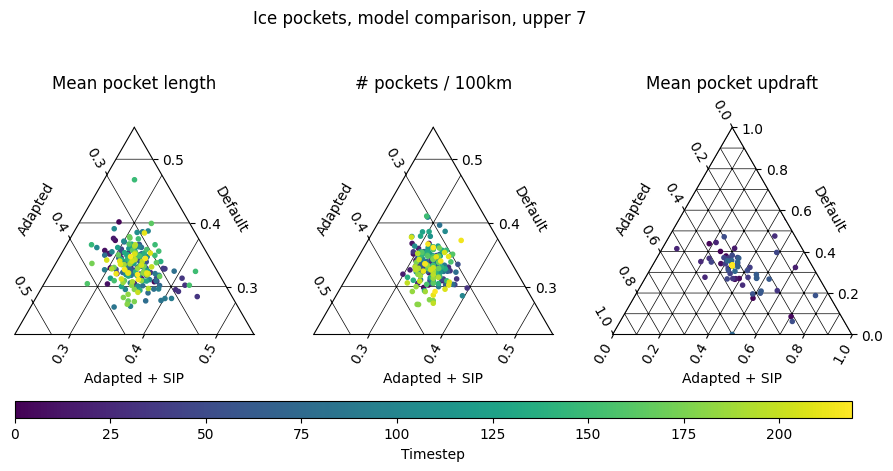

In [28]:
def ternary_plot():
    # Transformin data to 3xn array
    MorMeans = np.array([e.mean for e in MD3_mass_along])
    MorNpock = np.array([e.n_pockets for e in MD3_mass_along])
    MorUpdraft = np.array([e.mean_updraft for e in MD3_mass_along])

    for a in [MA3_mass_along, MAS3_mass_along]:
        MorMeans = np.concatenate([MorMeans, np.array([e.mean for e in a])])
        MorNpock = np.concatenate([MorNpock, np.array([e.n_pockets for e in a]) / 
                                            np.array([e.total_length for e in a]) * 100])
        MorUpdraft = np.concatenate([MorUpdraft, np.array([e.mean_updraft for e in a]) / 
                                            np.array([e.mean_updraft for e in a]) * 100])
        
    MorMeans = np.reshape(MorMeans, newshape=(220, 3))
    MorNpock = np.reshape(MorNpock, newshape=(220, 3))
    MorUpdraft = np.reshape(MorUpdraft, newshape=(220, 3))

    # Plotting in triangle
    t, l, r = get_triangular_grid()
    fig, ax = plt.subplots(1, 3, figsize=(10.8, 4.8), subplot_kw={'projection': 'ternary'})

    
    #ax1 = fig.add_subplot(121, projection='ternary')
    for i, x in enumerate(ax):
        x.triplot(t, l, r, color='k', linewidth=0.5)
        x.set_tlabel('Default')
        x.set_llabel('Adapted')
        x.set_rlabel('Adapted + SIP')
        if i != 2:
            x.set_ternary_min(0.25, 0.25, 0.25)
            x.set_ternary_max(0.55, 0.55, 0.55)
        x.taxis.set_label_position('tick1')
        x.laxis.set_label_position('tick1')
        x.raxis.set_label_position('tick1')

    p = ax[0].scatter(*zip(*MorMeans), c=np.arange(220), marker='.')
    ax[1].scatter(*zip(*MorNpock), c=np.arange(220), marker='.')
    ax[2].scatter(*zip(*MorUpdraft), c=np.arange(220), marker='.')
    plt.subplots_adjust(wspace=0.25)

    ax[0].set_title('Mean pocket length', y=1.15)
    ax[1].set_title('# pockets / 100km', y=1.15)
    ax[2].set_title('Mean pocket updraft', y=1.15)

    #cax = plt.axes([0.85, 0.1, 0.075, 0.8])

    fig.colorbar(p, ax=ax.ravel().tolist(), orientation='horizontal', label='Timestep', 
                fraction=0.07, aspect=50, pad=0.18)
    fig.suptitle('Ice pockets, model comparison, upper 7')

    plt.show()
ternary_plot()

In [22]:
def plot_segment_timeseries(res, ax=None, iwf_type='Mass', angle='Along', H=None, legend=True, title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    t0, t1 = res[0].t, res[-1].t + 1
    x = Mil3.XTIME.isel(Time=slice(0, 220))

    ax.set_ylabel('km | #/100km')
    ax.set_ylim([0, 30])
    ax.grid()
    ax.set_xlim(x[0], x[-1])
    axW = ax.twinx()
    axW.set_ylim(-0.055, 0.055)
    #axW.hlines(0, x[0], x[-1], linestyles='dashed', color='red')
    
    ax.plot(x, np.array([e.mean for e in res]), color='k', linewidth=3, label='Mean pocket length')
    ax.plot(x, np.array([e.n_pockets for e in res]) / 
            np.array([e.total_length for e in res]) * 100, linewidth=3, label='# pockets / 100km')
    

    conf = np.array([sms.DescrStatsW(e.all_pockets()).tconfint_mean() for e in res])
    ax.fill_between(x, conf[:, 0], conf[:, 1], alpha=0.3, color='k', label='95% confidence')

    
    if legend:
        ax.legend(loc='upper left', fontsize=10)
    #ax.set_title('Along-wind cloud-top mixed-phase pocket statistics, d03/{iwf_type}')
    ax.set_title(f'{iwf_type} concentration')
    if title is not None:
        ax.set_title(title)
    

    w = [e.mean_updraft for e in res]

  
    axW.plot(x, w, label='Pocket updraft', color='red', linestyle='solid')
    axW.set_ylabel('m/s')

    p = None
    if H is not None:
        p = axW.scatter(x, np.zeros(len(x)) + -0.055, c=[e.H for e in res], s=80, 
                    cmap='bwr', label='CT height', vmin=39, vmax=55)
    if legend:
        axW.legend(loc='upper right', fontsize=10)    
    return p 


Text(0.5, 0.98, 'Ice pockets, mass, upper 7')

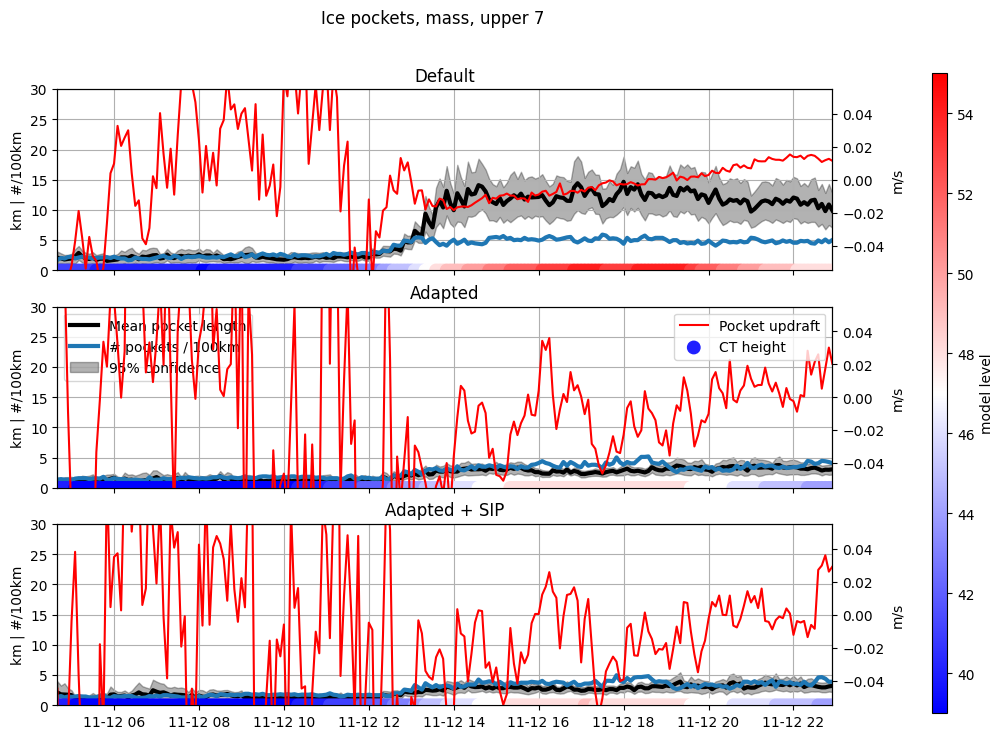

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)
plot_segment_timeseries(MD3_mass_along, ax=ax[0], H=True, title='Default', legend=False)
plot_segment_timeseries(MA3_mass_along, ax=ax[1], H=True, title='Adapted')
p = plot_segment_timeseries(MAS3_mass_along, ax=ax[2], H=True, legend=False, title='Adapted + SIP')

cax = fig.add_axes([1, 0.1, 0.015, 0.8])

fig.colorbar(p, cax=cax, label='model level')
fig.suptitle('Ice pockets, mass, upper 7')

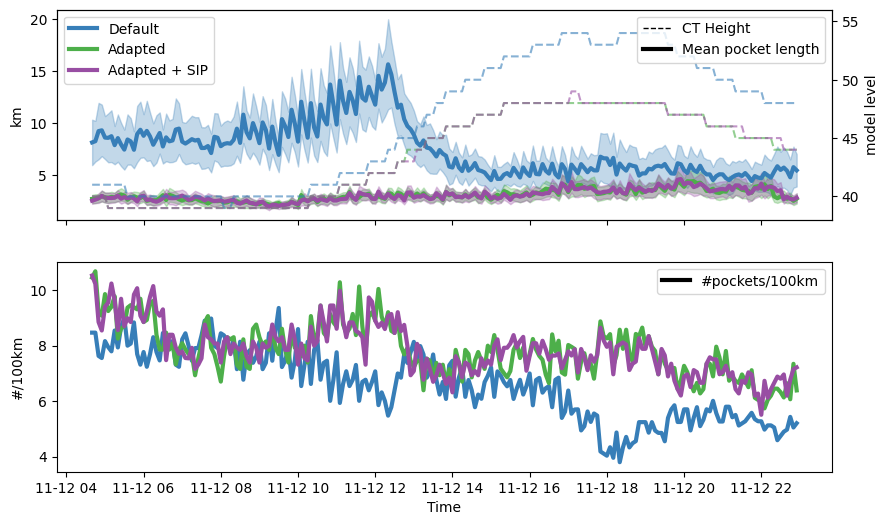

In [74]:
def compare_segments():
    plt.style.use('default')

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    t0, t1 = MD3_mass_along[0].t, MD3_mass_along[-1].t + 1
    x = Mil3.XTIME.isel(Time=slice(0, 220))

    data = [MD3_mass_along, MA3_mass_along, MAS3_mass_along]
    #Ts = [TD, TA, TAS]
    labels = ['Default', 'Adapted', 'Adapted + SIP']
    colors = ['#377eb8', '#4daf4a', '#984ea3']
    #ff7f00
    #ffff33
    #a65628
    #f781bf]

    axH = ax[0].twinx()
    axH.set_ylabel('model level')
    axH.set_ylim(38, 56)

    #axT = ax[1].twinx()
    #axT.set_ylabel('$^\circ$C')

    for res, lab, c in zip(data, labels, colors):
        ax[0].plot(x, np.array([e.mean for e in res]), color=c, linewidth=3, label=lab)
        axH.plot(x, [e.H for e in res], color=c, linestyle='dashed', alpha=0.6)
        
        ax[1].plot(x, np.array([e.n_pockets for e in res]) / 
                np.array([e.total_length for e in res]) * 100, linewidth=3, color=c)
        conf = np.array([sms.DescrStatsW(e.all_pockets()).tconfint_mean() for e in res])
        #axT.plot(x, T, linestyle='dashed', color=c, alpha=0.6)

        ax[0].fill_between(x, conf[:, 0], conf[:, 1], alpha=0.3, color=c)#, label='95% confidence')

    ax[0].legend(loc='upper left')

    handles = [Line2D([0], [0], color='k', lw=1, label='CT Height', linestyle='dashed'), 
            Line2D([0], [0], color='k', lw=3, label='Mean pocket length')]

    axH.legend(handles=handles, loc='upper right')


    #handles = [Line2D([0], [0], color='k', lw=1, label='CT Temperature', linestyle='dashed'), 
    #        Line2D([0], [0], color='k', lw=3, label='#pockets/100km')]
    handles = [Line2D([0], [0], color='k', lw=3, label='#pockets/100km')]
    ax[1].legend(handles=handles)
    ax[0].set_ylabel('km')
    ax[1].set_ylabel('#/100km')
    ax[1].set_xlabel('Time')
    plt.show()
compare_segments()

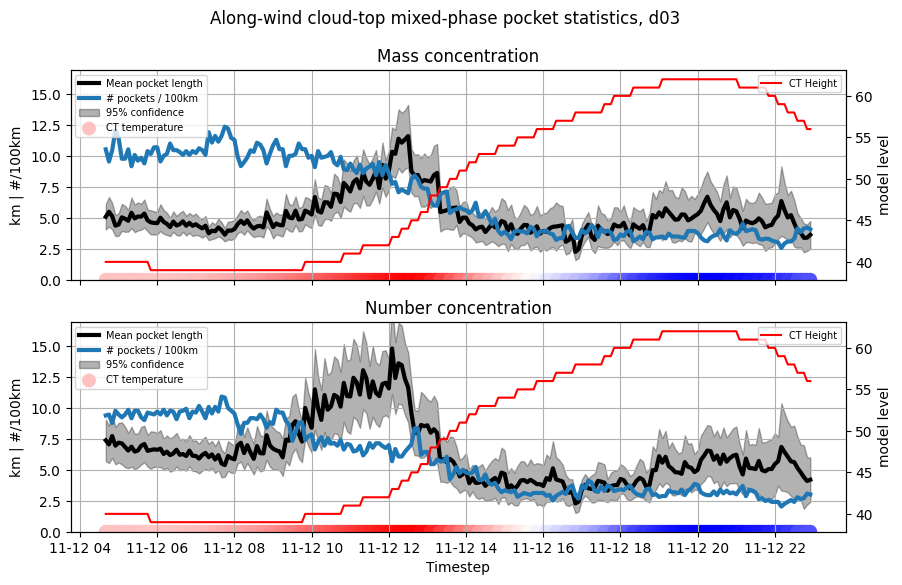

In [98]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle('Along-wind cloud-top mixed-phase pocket statistics, d03')
ax[1].set_xlabel('Timestep')
plot_segment_timeseries(mass_along, ax=ax[0], iwf_type='Mass')
plot_segment_timeseries(number_along, ax=ax[1], iwf_type='Number')
plt.show()

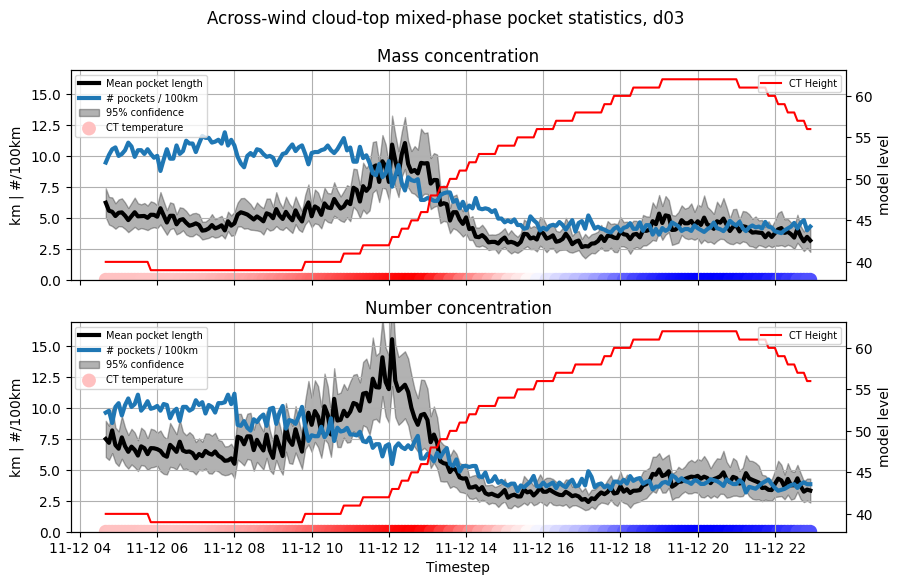

In [99]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle('Across-wind cloud-top mixed-phase pocket statistics, d03')
ax[1].set_xlabel('Timestep')
plot_segment_timeseries(mass_across, ax=ax[0], iwf_type='Mass')
plot_segment_timeseries(number_across, ax=ax[1], iwf_type='Number')
plt.show()

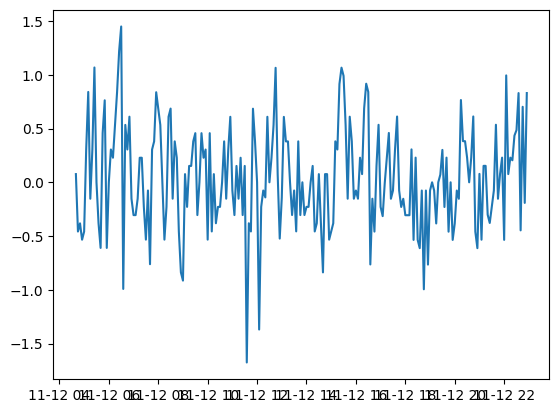

In [121]:
y1 = np.array([e.n_pockets for e in MA3_mass_along]) / np.array([e.total_length for e in MA3_mass_along]) * 100
y2 = np.array([e.n_pockets for e in MAS3_mass_along]) / np.array([e.total_length for e in MAS3_mass_along]) * 100
x = Mil3.XTIME.isel(Time=slice(0, 220))
plt.plot(x, y2 - y1)

In [122]:
y1 - y2

array([-0.07630934,  0.45785605,  0.38154671,  0.53416539,  0.45860248,
       -0.30573499, -0.84077122,  0.15286749, -0.30573499, -1.06833079,
        0.        ,  0.38098588,  0.61047473, -0.45785605, -0.76309342,
        0.61047473,  0.        , -0.30523737, -0.22892803, -0.53416539,
       -0.83940276, -1.22094947, -1.4498775 ,  0.99202144, -0.53416539,
       -0.30523737, -0.61047473,  0.15261868,  0.30523737,  0.30523737,
        0.15239435, -0.22859153, -0.22859153,  0.22859153,  0.53338024,
        0.07619718,  0.76197177, -0.30478871, -0.38098588, -0.83816894,
       -0.68577459, -0.53338024,  0.        ,  0.53338024,  0.22859153,
       -0.60957741, -0.68577459,  0.15239435, -0.38098588, -0.22859153,
        0.45718306,  0.83816894,  0.91436612, -0.07619718,  0.22859153,
       -0.15239435, -0.15239435, -0.38098588, -0.45718306,  0.30478871,
        0.        , -0.45718306, -0.22859153, -0.30478871,  0.53338024,
       -0.45718306,  0.45718306, -0.07619718,  0.38098588,  0.22

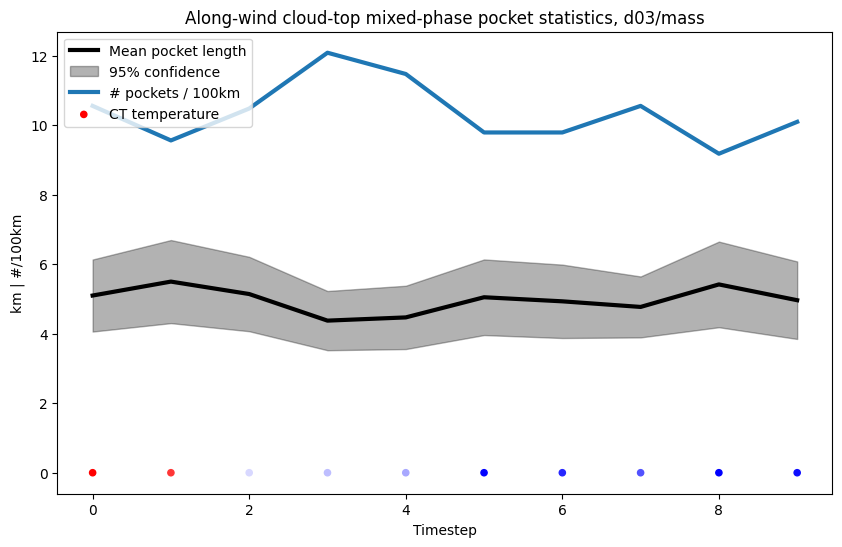

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
t0, t1 = res[0].t, res[-1].t + 1

x = np.arange(len(res))
y = np.array([e.mean for e in res])
ax.plot(x, y, color='k', linewidth=3, label='Mean pocket length')

conf = np.array([sms.DescrStatsW(e.all_pockets()).tconfint_mean() for e in res])



ax.fill_between(x, conf[:, 0], conf[:, 1], alpha=0.3, color='k', label='95% confidence')
#ax.plot(x, minl, linestyle='dashed', color='k')
#ax.plot(x, maxl, linestyle='dashed', color='k')

ax.plot(x, np.array([e.n_pockets for e in res]) / 
           np.array([e.total_length for e in res]) * 100, linewidth=3, label='# pockets / 100km')

T = select_top(calc_T(Mil3, slice(t0, t1)), CTL.isel(Time=slice(t0, t1)), n_levels=7).mean(
    dim=['bottom_top', 'west_east', 'south_north'])
ax.scatter(x, np.zeros(len(x)), c=T, s=20, cmap='bwr', label='CT temperature')

ax.legend(loc='upper left')
ax.set_title('Along-wind cloud-top mixed-phase pocket statistics, d03/mass')
ax.set_xlabel('Timestep')
ax.set_ylabel('km | #/100km')
plt.show()

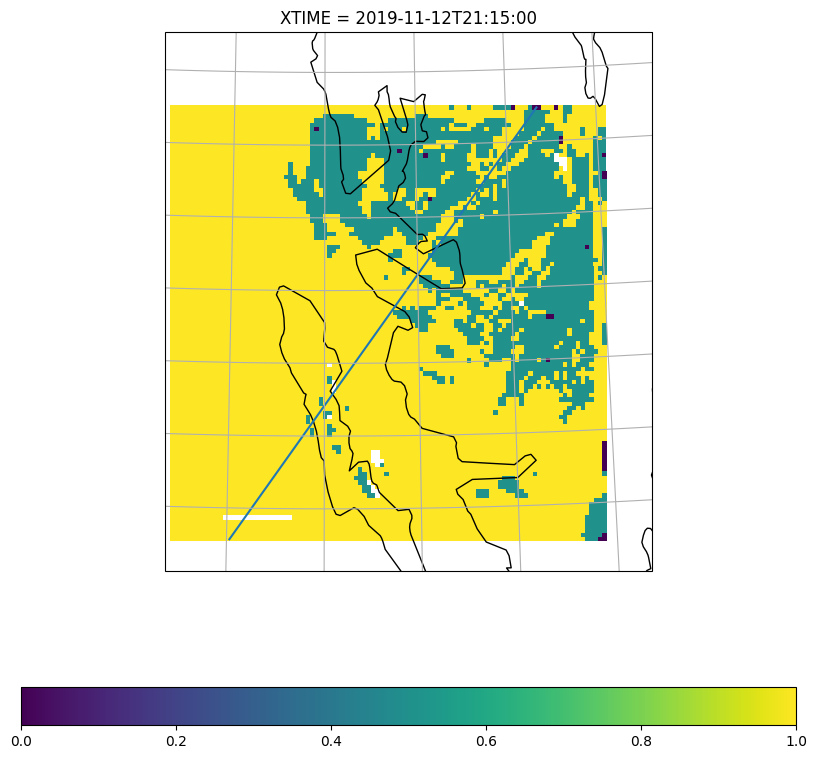

In [273]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.NorthPolarStereo(11.1)})

IWF_masked.isel(Time=199).plot(x='XLONG', y='XLAT', ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal'})

#ax.plot(lons, lats, transform=ccrs.PlateCarree(), color='red')
res[199].plot_transect(ax=ax)
ax.coastlines()
ax.set_extent([NYA.lon - 2.55, NYA.lon + 2.4, NYA.lat - 0.6, NYA.lat + 0.5], crs=ccrs.PlateCarree())
ax.gridlines()

### Plot windfield

In [95]:
def plot_windfield(t=0, datapath=Milbrandt3, p_level=800):
    # Open the NetCDF file
    ncfile = nc.Dataset(datapath)

    # Extract the pressure, geopotential height, and wind variables
    p = wrf.getvar(ncfile, "pressure", timeidx=t)
    z = wrf.getvar(ncfile, "z", units="dm", timeidx=t)
    ua = wrf.getvar(ncfile, "ua", units="m s-1", timeidx=t)
    va = wrf.getvar(ncfile, "va", units="m s-1", timeidx=t)
    wspd = wrf.getvar(ncfile, "wspd_wdir", units="m s-1", timeidx=t)[0,:]


    # Interpolate geopotential height, u, and v winds to pl hPa
    ht_pl = wrf.interplevel(z, p.isel(bottom_top=slice(0, -1)), p_level)
    u_pl = wrf.interplevel(ua, p, p_level)
    v_pl = wrf.interplevel(va, p, p_level)
    wspd_pl = wrf.interplevel(wspd, p, p_level)

    # Get the lat/lon coordinates
    lats, lons = wrf.latlon_coords(ht_pl)

    # Get the map projection information
    cart_proj = wrf.get_cartopy(ht_pl)

    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)

    ax.coastlines('50m', linewidth=0.8)

    # Add the pl hPa geopotential height contours
    levels = np.arange(750., 850., 60.)
    contours = plt.contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(ht_pl),
                        levels=levels, colors="black",
                        transform=ccrs.PlateCarree())
    plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

    # Add the wind speed contours
    levels = np.arange(5, 25, 1)
    wspd_contours = plt.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(wspd_pl),
                                levels=levels,
                                transform=ccrs.PlateCarree())
    plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", pad=.05, label='m s-1')

    # Add the pl hPa wind barbs, only plotting every 125th data point.
    plt.barbs(wrf.to_np(lons[::12,::12]), wrf.to_np(lats[::12,::12]),
            wrf.to_np(u_pl[::12, ::12]), wrf.to_np(v_pl[::12, ::12]),
            transform=ccrs.PlateCarree(), length=6)

    # Set the map bounds
    ax.set_xlim(wrf.cartopy_xlim(ht_pl))
    ax.set_ylim(wrf.cartopy_ylim(ht_pl))

    ax.gridlines()

    plt.title(f"{p_level} hPa Height Wind Speed, {domain}, t={t}")
    return fig
#plot_windfield(1, Milbrandt3, 750)

In [94]:
animate(plot_windfield, anim_title='wind_animation_d03')

100%|██████████| 232/232 [05:19<00:00,  1.38s/it]


###  Next

I'm starting to wonder if this case maybe isn't the best to look for pockets. At least the way I'm picturing it pockets are more important or relevant in persistent MPC's? This cloud looks to me like it should not be very persistent at all since it just suddenly rises and the cloud top becomes glaciated kikcing off the precip. So I'm not sure how to look for any pockets here... 
I thought about following some trajectories at cloud top and keeping track of the stats on how long each "pocket" of liquid, ice and mixed-phase are, but in this case I can't see a clear way to do that when the run is so different before and after the glaciation.


Now look at IWF for number concentration (multiply ice by factor 1000 do make comparable!)
And look at time for glaciation stuff (around 13:00) for d01 as well. Maybe this has to do with nudging!!

In [ ]:
#LAST WORKING BEFORE PARALLELLIZATION
def consecutive(arr):
    return np.split(arr, np.where(np.diff(arr) != 1)[0] + 1)

def get_wind_at_CT(data, timeidx, x, y):
    '''Find wind at cloud top level at given location and time'''
    wind = wrf.getvar(nc.Dataset(Milbrandt3), "wspd_wdir", units="m s-1", timeidx=timeidx)[0,:]
    CTL = find_top(data, Milbrandt3, t=1).isel(south_north=60, west_east=50)
    return float(wind.isel(bottom_top=CTL, west_east=x, south_north=y))


def segment_lengths(data, datapath, xy, condition='IWF > 0.5', mass=True, n_levels=7, cld_thrsh=0.5):
    '''Find length of consecutive phase segements'''
    wind = wrf.getvar(nc.Dataset(datapath), "wspd_wdir", units="m s-1", 
                      timeidx=wrf.ALL_TIMES)[0,:]

    CTL = find_top(data, datapath, cld_thrsh=cld_thrsh)

    IWF = select_top(iwf_calc(data, mass=mass, cld_thrsh=cld_thrsh), 
                     find_top(data, datapath, cld_thrsh=cld_thrsh), 
                     n_levels=n_levels).mean(dim='bottom_top')

    IWF = xr.where(IWF > 0.9, x = 1, y = IWF)
    IWF = xr.where(IWF <= 0.1, x = 0, y = IWF)
    IWF = xr.where((IWF > 0.1) & (IWF < 0.9), x = 0.5, y = IWF)

    calculations = {}

    #def f(i):
        #x, y = int(np.floor(i/10)), int(i%10)
    for e in xy:
        x, y = e
        xy_IWF = IWF.isel(south_north=y, west_east=x)
        P = np.where(eval('xy_IWF' + condition))[0]
        segment = consecutive(P)
        
        lengths = []
        for e in segment:
            length = 0
            for timeidx in e:
                H = int(CTL.isel(Time=timeidx, south_north=y, west_east=x))
                wspd = float(wind.isel(Time=timeidx, bottom_top=H, south_north=y, west_east=x))
                length += wspd * 5 * 60 # m/s * 5min timestep = meters
            lengths.append(length)
        calculations[(x, y)] = np.array(lengths)
    return calculations

res = segment_lengths(Mil3, Milbrandt3, xy=xy, condition='> 0.5')

## Comments
- How do we define 'pockets' of mixed phase to apply clustering algorithm on?
    - Are the traces around the liquid phase pocket in the middle of the cloud really mixed-phase pockets? In a clustering algorithm based purely on distances I think these would look strange
    
- Isolate the two peaks more. In 2d hist: temp above and below -10, and IWF above and below 0.5.

What about looking at upper 5 levels or so (start from cloud top, and add 5 cells below it). If they are all ice - completely glaciated, if not then mixed-phase or liquid phase is present. Maybe better way to quantify cloud pockets. Can then count in the spatial to see how many and how big the pockets typically are.